## Detailed Marketing: Cohort, Pảeto, RFM, Forecast

<a id='section-top'></a>
# Table Of Contents
* .[Introduction](#section-intro)

* .[1. General Infos & Playing with Features](#section-one)

*  .[2. Cohort Analysis](#section-two)
    - [2.1 Retention Rate](#section-two-one)
    
*  .[3. Pareto Principle](#section-three)
    - [3.1 Pareto Chart For Customers](#section-three-one)
    - [3.2 Pareto Chart For Products](#section-three-two)
    
* .[4. RFM Analysis](#section-tree)
    - [4.1 Preparing RFM Table](#section-four-one)
    - [4.2 RFM Segments](#section-four-two)
    - [4.3 Visualizing RFM Grid](#section-four-three)
    - [4.4 Customer Segmentation With Using RFM Metrics](#section-four-five)
    
* [5. Forecasting With prophet](#section-five)
    - [5.1 Data Preparation For Time Series](#section-five-one)
        - [5.1.1 Weekly](#section-five-one-one)
        - [5.1.2 Daily](#section-five-one-two)
     - [5.2 Stationarity](#section-five-two)
         - [5.2.1 Augmented Dickey-Fuller Test](#section-five-two-one)
     - [5.3. Seasonality, Decomposition](#section-five-three)
     - [5.4 Modeling](#section-five-four)
         - [5.4.1. Simple Model](#section-five-four-two)
         - [5.4.2. Prophet's parameters](#section-five-fpur-two)
         - [5.4.3. Forecasting Future](#section-five-four-three)
         
* [Resource, Readings](#section-zero)
* [Conclusion](#section-conlution)

**First version : 14.8.2021**

**Last Edit: 5.10.2023**

<a id="section-intro"></a>

# Introduction

This is Online Retail dataset from UCI Machine Learning Repository. It contains transactions from 2010 and 2011.

For other datasets from UCI ML https://archive.ics.uci.edu/ml/datasets.php

This is my first work about marketing. I have finished Datacamp's marketing course for a long time ago, but didn't practise it.

I prepare this notebook for practising all these stuff.

This is my full work, I also separate it into chapters. You can take a look to chapters individually.

https://www.kaggle.com/mustafacicek/online-retail-part-i-preparing-getting-insights

https://www.kaggle.com/mustafacicek/marketing-analytics-cohort-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-pareto-principle

https://www.kaggle.com/mustafacicek/marketing-analytics-rfm-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-forecasting

You can reach prepared data from here https://www.kaggle.com/mustafacicek/online-retail-final

<a id="section-zero"></a>

# Resources, Readings

Datacamp's https://www.datacamp.com/courses/customer-segmentation-in-python course

https://www.kaggle.com/allunia/e-commerce-sales-forecast I inspired some parts in analysing features.

https://www.kaggle.com/fabiendaniel/customer-segmentation It is also exciting notebook, probably you have already looked.

Basic readings about concept:

https://clevertap.com/blog/cohort-analysis/

https://en.wikipedia.org/wiki/Pareto_principle

https://www.investopedia.com/terms/p/paretoprinciple.asp

https://clevertap.com/blog/rfm-analysis/

https://www.wigzo.com/blog/rfm-analysis-for-ecommerce/

https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

https://futurice.com/blog/know-your-customers-with-rfm

## Import libraries and Load data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
import statsmodels.api as sm
import warnings 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

plt.rcParams['axes.facecolor'] = "#A2A2A2"
plt.rcParams['axes.grid'] =1

In [3]:
df = pd.read_csv("D:\\IBM_Data_Science\\Data_set\\Data_Kagle_Github\\OnlineRetail.csv",encoding = 'unicode_escape')

In [4]:
display(df.head())

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [5]:
print(df.shape)

(541909, 8)


**Check information of date frame**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- We have missing values for column Description and CustomerID. Go deeper.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df[df.Description.isnull()]

InvoiceNo StockCode Description  Quantity      InvoiceDate  UnitPrice  \
622       536414     22139         NaN        56  12/1/2010 11:52        0.0   
1970      536545     21134         NaN         1  12/1/2010 14:32        0.0   
1971      536546     22145         NaN         1  12/1/2010 14:33        0.0   
1972      536547     37509         NaN         1  12/1/2010 14:33        0.0   
1987      536549    85226A         NaN         1  12/1/2010 14:34        0.0   
...          ...       ...         ...       ...              ...        ...   
535322    581199     84581         NaN        -2  12/7/2011 18:26        0.0   
535326    581203     23406         NaN        15  12/7/2011 18:31        0.0   
535332    581209     21620         NaN         6  12/7/2011 18:35        0.0   
536981    581234     72817         NaN        27  12/8/2011 10:33        0.0   
538554    581408     85175         NaN        20  12/8/2011 14:06        0.0   

        CustomerID         Country  
622            NaN  United Kingdom  
1970           NaN  United Kingdom  
1971           NaN  United Kingdom  
1972           NaN  United Kingdom  
1987           NaN  United Kingdom  
...            ...             ...  
535322         NaN  United Kingdom  
535326         NaN  United Kingdom  
535332         NaN  United Kingdom  
536981         NaN  United Kingdom  
538554         NaN  United Kingdom  

[1454 rows x 8 columns]

- When desdription is null , we have 0 unit price and missing customer ids. Let's check for whole data.

In [9]:
 # Checking unique values of Desription variables
df[df.Description.isnull()].CustomerID.nunique()

0

In [10]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

- When description is null, we have no available customer and zero unit price for all data. Let's drop nan values.

In [11]:
df =df[df.Description.notnull()]


In [12]:
df[df.CustomerID.isnull()]

InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
1443    12/1/2010 14:32       2.51         NaN  United Kingdom  
1444    12/1/2010 14:32       2.51         NaN  United Kingdom  
1445    12/1/2010 14:32       0.85         NaN  United Kingdom  
1446    12/1/2010 14:32       1.66         NaN  United Kingdom  
1447    12/1/2010 14:32       1.66         NaN  United Kingdom  
...                 ...        ...         ...             ...  
541536  12/9/2011 10:26       4.13         NaN  United Kingdom  
541537  12/9/2011 10:26       4.13         NaN  United Kingdom  
541538  12/9/2011 10:26       4.96         NaN  United Kingdom  
541539  12/9/2011 10:26      10.79         NaN  United Kingdom  
541540  12/9/2011 10:26    1714.17         NaN  United Kingdom  

[133626 rows x 8 columns]

At first look, we can see records that hvae missing customer id, ther is no specified charecterics. Stock Code contain non-numeric i,e DOT , it os a cute for examining stock codes.

In [13]:
print("We have {} observation".format(df.shape[0]))
df =df[df.CustomerID.notnull()]
print("We have {} observation after removing unknow customer".format(df.shape[0]))

We have 540455 observation
We have 406829 observation after removing unknow customer


In [14]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- We are done wwith values filred with some denotations. "NAN",'na', "Unknow" and spoon. Let's check them.

In [15]:
df[df.Description.str.len()<5]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [16]:
df.InvoiceNo.value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [17]:
df[df['InvoiceNo'].str.startswith("C")]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  
141      12/1/2010 9:41      27.50     14527.0  United Kingdom  
154      12/1/2010 9:49       4.65     15311.0  United Kingdom  
235     12/1/2010 10:24       1.65     17548.0  United Kingdom  
236     12/1/2010 10:24       0.29     17548.0  United Kingdom  
237     12/1/2010 10:24       0.29     17548.0  United Kingdom  
...                 ...        ...         ...             ...  
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom  
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom  
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom  
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom  
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom  

[8905 rows x 8 columns]

- Cancelled invoices have nagative quantity

In [18]:
df['Cancelled'] = df['InvoiceNo'].apply(lambda x:1 if x.startswith("C") else 0)  

Cancel we have cancellation record, and before cancellation. I mean, for example, we have C5356379, have we 53679?

In [19]:
cancelled_invoiceNo = df[df.Cancelled ==1].InvoiceNo.tolist()
cancelled_invoiceNo =[x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [20]:
df[df['InvoiceNo'].isin(cancelled_invoiceNo)]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Cancelled]
Index: []

Nothing, we have just cancellation:

Well, may be we have different pattern about InvoiceNo.Let's check it.

In [21]:
df[df.InvoiceNo.str.len() !=6]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  Cancelled  
141      12/1/2010 9:41      27.50     14527.0  United Kingdom          1  
154      12/1/2010 9:49       4.65     15311.0  United Kingdom          1  
235     12/1/2010 10:24       1.65     17548.0  United Kingdom          1  
236     12/1/2010 10:24       0.29     17548.0  United Kingdom          1  
237     12/1/2010 10:24       0.29     17548.0  United Kingdom          1  
...                 ...        ...         ...             ...        ...  
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom          1  
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom          1  
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom          1  
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom          1  
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom          1  

[8905 rows x 9 columns]

No, we only have proper invoices cancelleations for InvoiceNo. We don't have any differnt pattern.

In [22]:
df =df[df.Cancelled ==0]

Stock Codes generally contrains 6 difit numerical codes.

In [23]:
# Count values bu A --> Z
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [24]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

- It looks like data contain more than customer transactions. I will drop them.

In [25]:
df[df.StockCode.str.len()>5].StockCode.value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: StockCode, Length: 875, dtype: int64

In [26]:
df[df.StockCode.str.len()>5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
                                       ... 
PURPLE/BLUE CERAMIC CANDLE HOLDER         1
ORANGE PENDANT TRIPLE SHELL NECKLAC       1
ROSE PENDANT TRIPLE SHELL NECKLACE        1
BLACK CHRISTMAS FLOCK DROPLET             1
CURIOUS IMAGES SCRAP BOOK SET             1
Name: Description, Length: 887, dtype: int64

Some stock codes have a letter at the and of thier codes. I don't know what they refers so I will keep them.

In [27]:
df = df[~df.StockCode.str.contains("a-zA-Z")]

In [28]:
df["Description"] = df['Description'].str.lower()

i just standard description with converting them to all lowercase charaterics.

- Stock Codes Description

In [29]:
df.groupby("StockCode")['Description'].nunique()[df.groupby("StockCode")["Description"].nunique() !=1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64

213 Stock codes have nore than one desription. Let's check some of them.

In [30]:
df[df.StockCode =="16156L"].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [31]:
df[df.StockCode == "17107D"].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [32]:
df[df.StockCode =='90014C'].Description.value_counts()

silver/black orbit necklace        2
silver and black orbit necklace    1
Name: Description, dtype: int64

- Seens we have just a litle differences t =between them i.e "," or '/'.

In [33]:
df.CustomerID.value_counts()

17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
           ... 
15313.0       1
17846.0       1
13185.0       1
16953.0       1
16737.0       1
Name: CustomerID, Length: 4339, dtype: int64

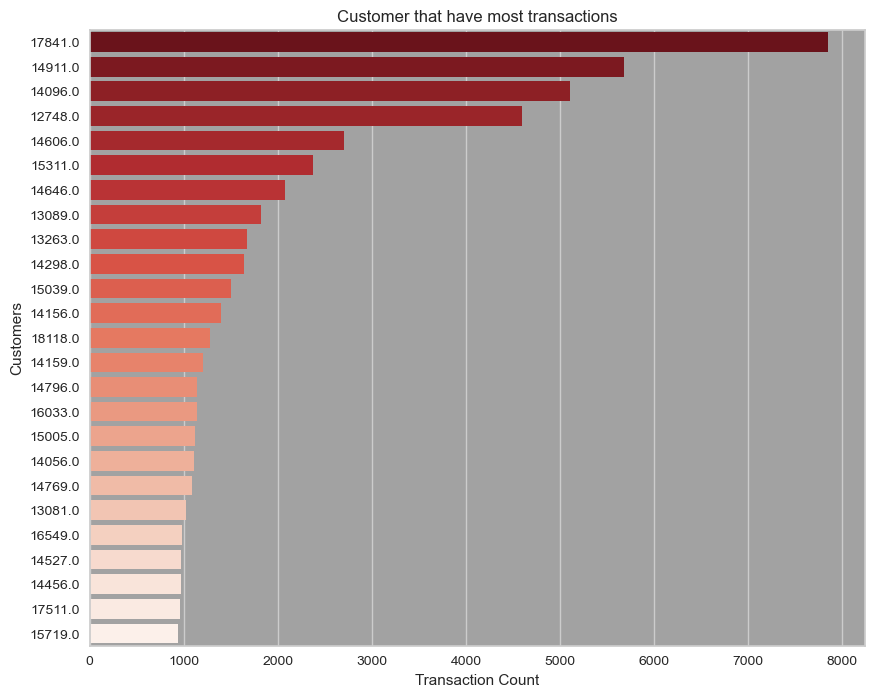

In [34]:
customer_counts =df.CustomerID.value_counts().sort_values(ascending=False).head(25)
fig,ax = plt.subplots(figsize=(10,8))

sns.barplot(y=customer_counts.index, x=customer_counts.values, orient ='h',
           ax=ax, order = customer_counts.index, palette ="Reds_r")
plt.title("Customer that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()


In [35]:
df.Country.value_counts()

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

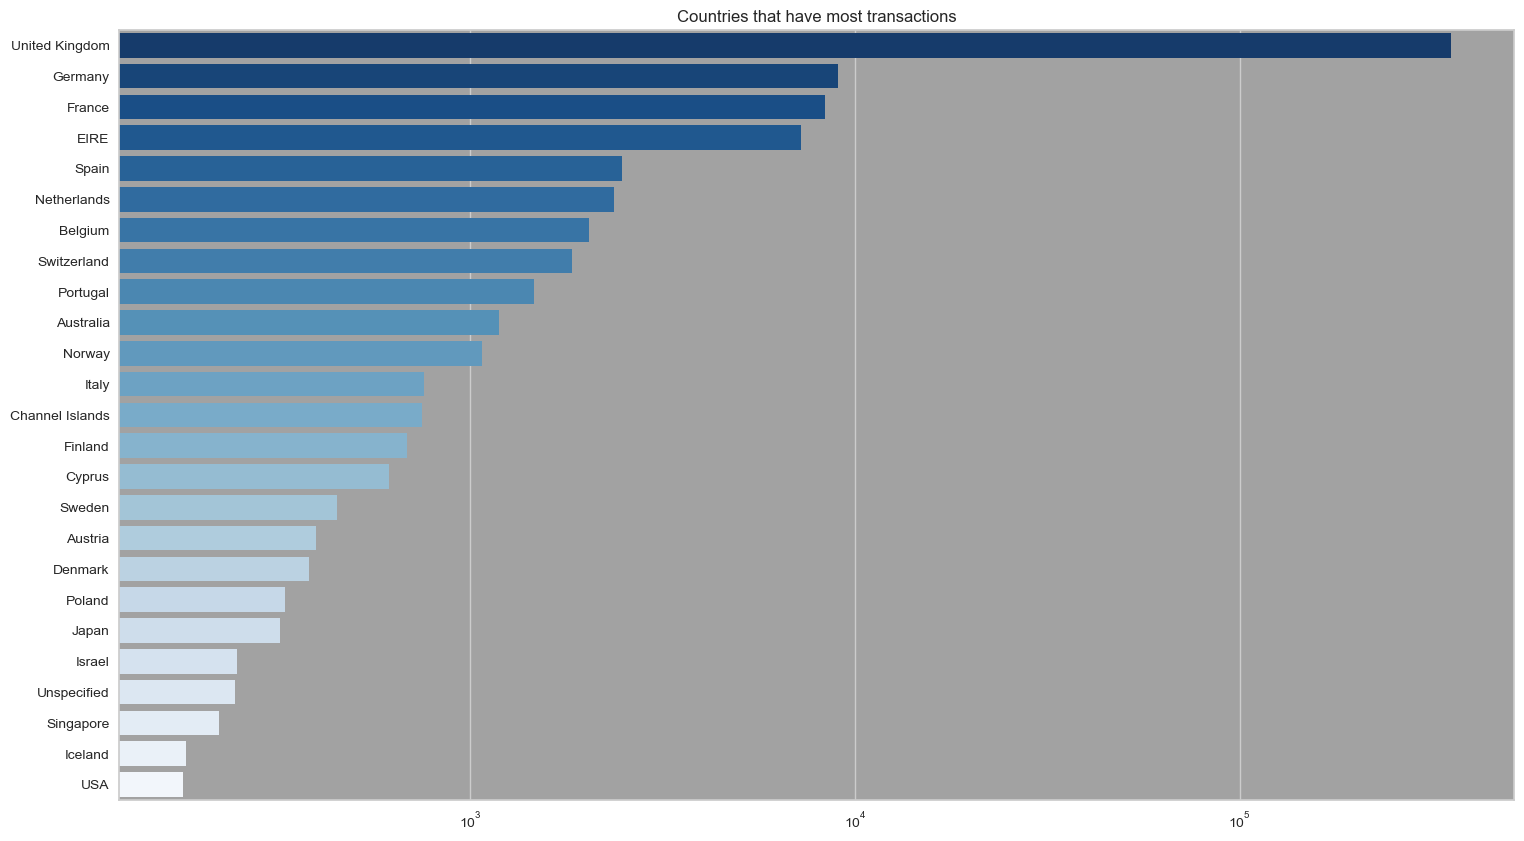

In [36]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig,ax =plt.subplots(figsize=(18,10))

sns.barplot(x =country_counts.values, y =country_counts.index, orient='h',
           ax=ax, order = country_counts.index,palette='Blues_r')
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [37]:
df['UnitPrice'] .describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

0 unit price?

In [38]:
df[df.UnitPrice ==0].head()

InvoiceNo StockCode                   Description  Quantity  \
9302     537197     22841  round cake tin vintage green         1   
33576    539263     22580  advent calendar gingham sack         4   
40089    539722     22423      regency cakestand 3 tier        10   
47068    540372     22090       paper bunting retrospot        24   
47070    540372     22553        plasters in tin skulls        24   

            InvoiceDate  UnitPrice  CustomerID         Country  Cancelled  
9302    12/5/2010 14:02        0.0     12647.0         Germany          0  
33576  12/16/2010 14:36        0.0     16560.0  United Kingdom          0  
40089  12/21/2010 13:45        0.0     14911.0            EIRE          0  
47068    1/6/2011 16:41        0.0     13081.0  United Kingdom          0  
47070    1/6/2011 16:41        0.0     13081.0  United Kingdom          0

i didn't pattern. So, I remove them

In [39]:
print("We have {} observations". format(df.shape[0]))
df =df[df.UnitPrice>0]
print("We have {} observation safter removing records that have 0 unit price ".format(df.shape[0]))

We have 397924 observations
We have 397884 observation safter removing records that have 0 unit price 


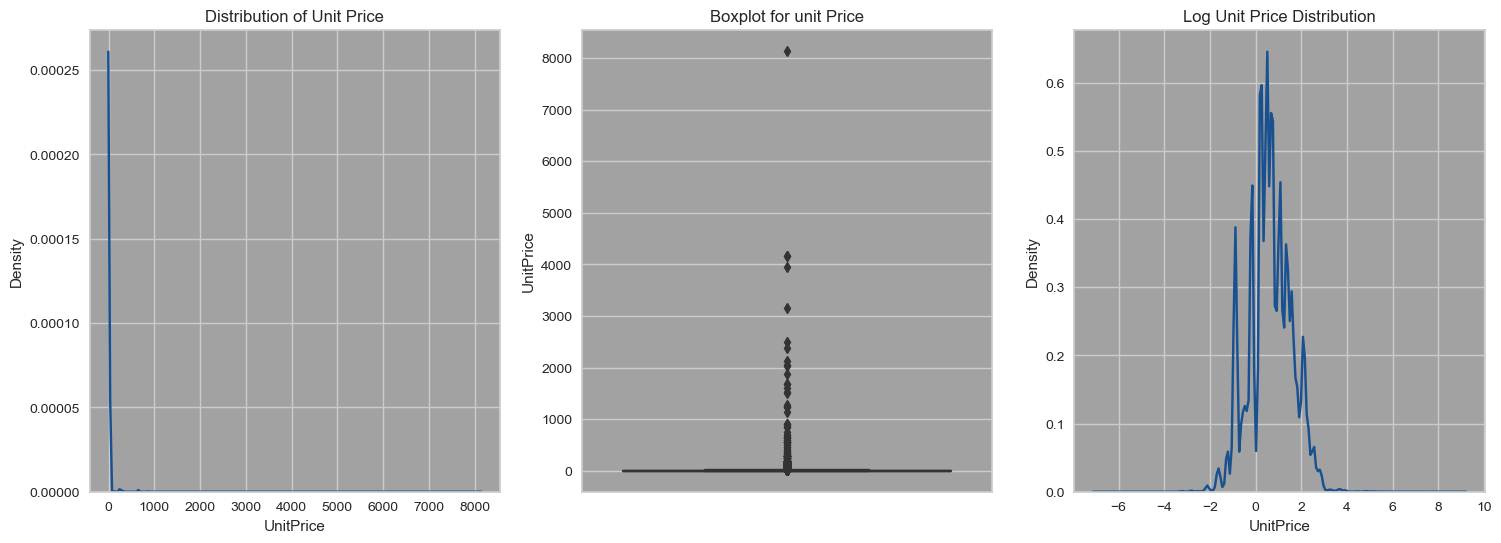

In [40]:
fig,axes = plt.subplots(1,3, figsize = (18,6))

sns.kdeplot(df['UnitPrice'], ax=axes[0], color='#195190').set_title("Distribution of Unit Price")
sns.boxplot(y=df['UnitPrice'],ax=axes[1],color="#195190").set_title("Boxplot for unit Price")
sns.kdeplot(np.log(df['UnitPrice']), ax=axes[2], color ="#195190").set_title("Log Unit Price Distribution")

plt.show()

In [41]:
print("Lower limit for UnitPrice:"+ str(np.exp(-2)))
print("Upper limit for UnitPrice:"+ str(np.exp(3)))

Lower limit for UnitPrice:0.1353352832366127
Upper limit for UnitPrice:20.085536923187668


In [42]:
np.quantile(df.UnitPrice,0.99)

14.95

In [43]:
print("We have {} observations". format(df.shape[0]))

df =df[(df.UnitPrice>0.1)& (df.UnitPrice<20)]
print("We have {} observation after removing unit prices smaller than 0.1 and greater than 20 ".format(df.shape[0]))

We have 397884 observations
We have 396462 observation after removing unit prices smaller than 0.1 and greater than 20 


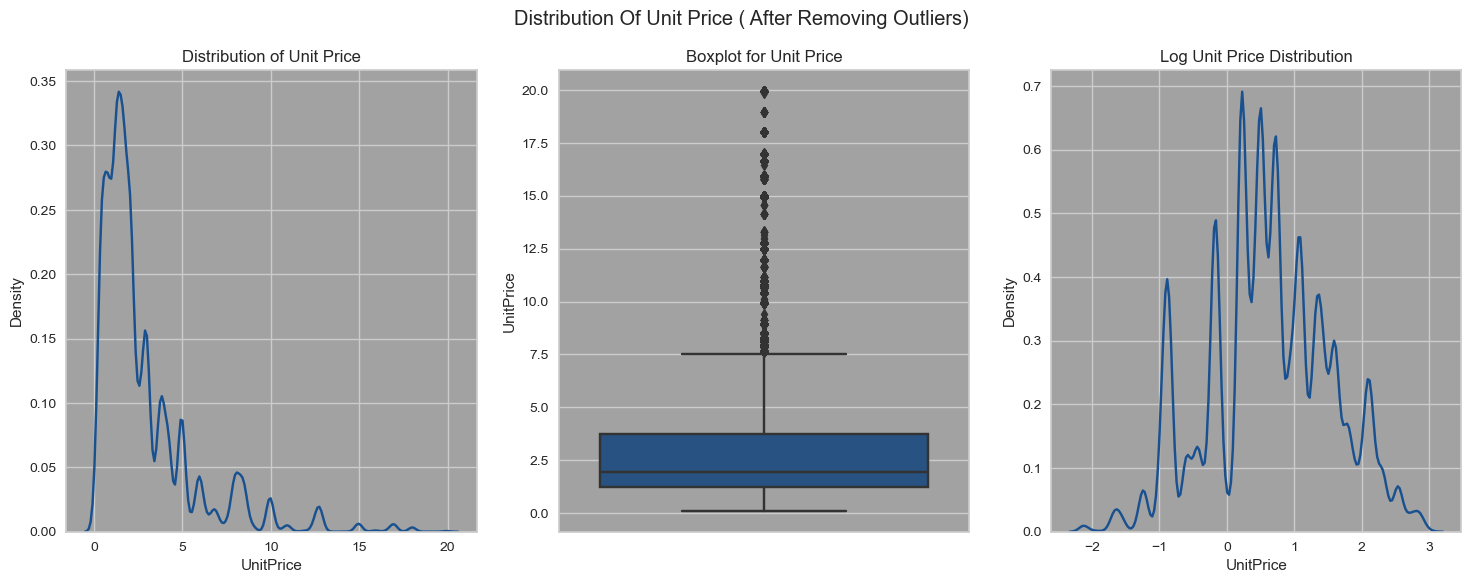

In [44]:
fig, axes = plt.subplots(1,3, figsize=(18,6))

sns.kdeplot(df['UnitPrice'], ax = axes[0], color ='#195190'). set_title("Distribution of Unit Price")
sns.boxplot(y=df['UnitPrice'], ax =axes[1], color ="#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df['UnitPrice']), ax =axes[2], color ="#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution Of Unit Price ( After Removing Outliers)")
plt.show()

In [45]:
df['Quantity'].describe()

count    396462.000000
mean         12.933943
std         179.461050
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Text(0.5, 1.0, 'Log Quantity ')

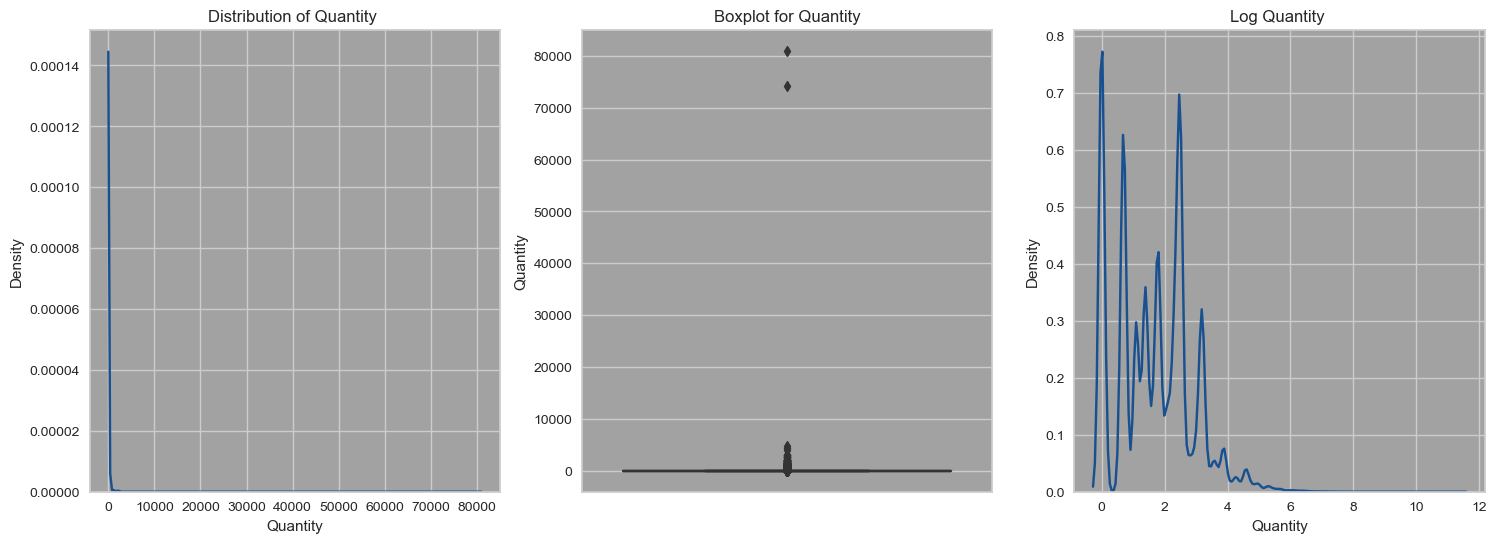

In [46]:
fig, axes = plt.subplots(1,3, figsize =(18,6))

sns.kdeplot(df['Quantity'], ax = axes[0], color ='#195190').set_title("Distribution of Quantity ")
sns.boxplot(y =df['Quantity'], ax = axes[1], color='#195190').set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df['Quantity']), ax = axes[2], color ='#195190').set_title("Log Quantity ")

In [47]:
# Upper limit of quantity
print("Upper limit for Quantity:" + str(np.exp(5)))

Upper limit for Quantity:148.4131591025766


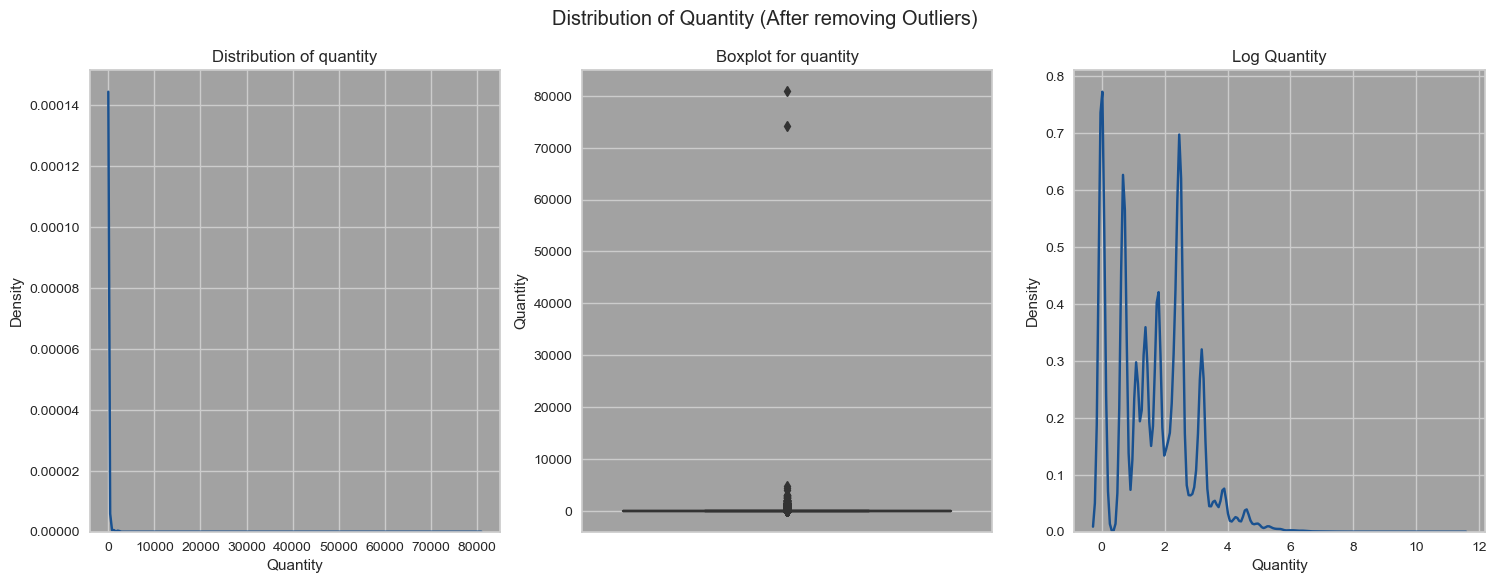

In [48]:
fig,axes = plt.subplots(1,3,figsize =(18,6))

sns.kdeplot(df['Quantity'], ax =axes[0], color='#195190').set_title("Distribution of quantity")
sns.boxplot(y =df['Quantity'], ax = axes[1], color ='#195190').set_title("Boxplot for quantity")
sns.kdeplot(np.log(df['Quantity']), ax=axes[2], color='#195190').set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After removing Outliers)")
plt.show()

In [49]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [50]:
df.drop("Cancelled", axis =1, inplace = True)
df.to_csv("Online_retail_final.csv",index=False)

## 2) Cohort Analysis

A cohort simply means that a group of people they have same characteristics.

Generally, we have three type of cohort analysis:

   - **Time cohorts** or **Acquisition cohorts**: Groups are divided by first activity.
   - **Behavior cohorts** or **Segment-Based cohorts**: Groups are divided by their behaivors and actions about your service.
   - **Size cohorts**: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.


Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.

Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.

Cohort analysis proves to be valuable because it helps to separate growth metrics from engagement metrics as growth can easily mask engagement problems. In reality, the lack of activity of the old users is being hidden by the impressive growth numbers of new users, which results in concealing the lack of engagement from a small number of people.

*https://clevertap.com/blog/cohort-analysis/

Cohort analysis is a better way of looking at data. Its application is not limited to a single industry or function. For example, eCommerce companies can use cohort analysis to spot products that have more potential for sales growth. In digital marketing, it can help identify web pages that perform well based on time spent on websites, conversions or sign-ups. In product marketing, this analysis can be used to identify the success of feature adoption rate and also to reduce churn rates.

*https://www.moengage.com/blog/growth-tactic-1-how-to-use-cohort-analysis-to-measure-customer-retention/

In [51]:
print("Min date:{} \nMax date {}".format(df.InvoiceDate.min(),df.InvoiceDate.max()))
print("Time difference is :{}".format(df.InvoiceDate.max()- df.InvoiceDate.min()))

Min date:2010-12-01 08:26:00 
Max date 2011-12-09 12:50:00
Time difference is :373 days 04:24:00


Our dataset contains invoice records for more than one year. Let's apply cohort analysis. We can create mothly cohorts.

We will group customers for first invoice record. Cohort index will be number of month since first transaction.

In [52]:
def get_month(x): return dt.datetime (x.year,x.month,1)

def get_dates(df,col):
    
    year =df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year,month,day

In [53]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['CohortMonth'] = df.groupby("CustomerID")['InvoiceMonth'].transform("min")

In [54]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   white hanging heart t-light holder         6   
1    536365     71053                  white metal lantern         6   
2    536365    84406B       cream cupid hearts coat hanger         8   
3    536365    84029G  knitted union flag hot water bottle         6   
4    536365    84029E       red woolly hottie white heart.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

  InvoiceMonth CohortMonth  
0   2010-12-01  2010-12-01  
1   2010-12-01  2010-12-01  
2   2010-12-01  2010-12-01  
3   2010-12-01  2010-12-01  
4   2010-12-01  2010-12-01

In [55]:
invoice_year, invoice_month, invoice_day = get_dates(df,"InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df,"CohortMonth")

year_diff = invoice_year-cohort_year
month_diff = invoice_month - cohort_month
df['CohortIndex'] = 12*year_diff + month_diff + 1

In [56]:
cohort_data = df.groupby(['CohortIndex', 'CohortMonth'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index ="CohortMonth", columns ="CohortIndex", values ="CustomerID")
cohort_pivot

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   884.0  324.0  285.0  338.0  320.0  352.0  320.0  307.0  311.0   
2011-01-01   414.0   92.0  111.0   95.0  134.0  120.0  103.0  101.0  125.0   
2011-02-01   379.0   71.0   71.0  108.0  102.0   93.0   96.0  104.0   94.0   
2011-03-01   451.0   67.0  113.0   90.0  101.0   76.0  120.0  104.0  126.0   
2011-04-01   299.0   63.0   61.0   62.0   58.0   68.0   65.0   78.0   22.0   
2011-05-01   283.0   54.0   49.0   49.0   59.0   65.0   75.0   27.0    NaN   
2011-06-01   242.0   42.0   38.0   65.0   56.0   80.0   23.0    NaN    NaN   
2011-07-01   188.0   35.0   38.0   42.0   51.0   21.0    NaN    NaN    NaN   
2011-08-01   170.0   35.0   42.0   41.0   21.0    NaN    NaN    NaN    NaN   
2011-09-01   298.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   358.0   85.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   323.0   37.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13  
CohortMonth                              
2010-12-01   349.0  329.0  445.0  235.0  
2011-01-01   136.0  151.0   48.0    NaN  
2011-02-01   116.0   26.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

<a id="section-two-one"></a>

# 2.1) Retention Rate

![](https://images.ctfassets.net/vrkkgjbn4fsk/7KUaWGQ9IJvf85OheLucgk/e03a27e5c68cc317b38dda354fee504d/how_to_calculate_user_retention_rate)

*https://amplitude.com/blog/how-to-calculate-retention-rate-b2b-saas

Retention tables show a group of people that visited your site or used your app for the first time during a certain time frame. They also display the progressive ‘drop-off’ or decline in activity over time for that particular group (a cohort).

Marketers can use Retention tables to analyze the quality of users brought by a marketing campaign and compare it to other sources of traffic.

*https://www.smartlook.com/blog/retention-tables-introduction/

In [57]:
cohort_sizes = cohort_pivot.iloc[:,0]

retention = cohort_pivot.divide(cohort_sizes, axis =0)
retention.index = retention.index.strftime("%Y-%m")

retention

CohortIndex   1         2         3         4         5         6         7   \
CohortMonth                                                                    
2010-12      1.0  0.366516  0.322398  0.382353  0.361991  0.398190  0.361991   
2011-01      1.0  0.222222  0.268116  0.229469  0.323671  0.289855  0.248792   
2011-02      1.0  0.187335  0.187335  0.284960  0.269129  0.245383  0.253298   
2011-03      1.0  0.148559  0.250554  0.199557  0.223947  0.168514  0.266075   
2011-04      1.0  0.210702  0.204013  0.207358  0.193980  0.227425  0.217391   
2011-05      1.0  0.190813  0.173145  0.173145  0.208481  0.229682  0.265018   
2011-06      1.0  0.173554  0.157025  0.268595  0.231405  0.330579  0.095041   
2011-07      1.0  0.186170  0.202128  0.223404  0.271277  0.111702       NaN   
2011-08      1.0  0.205882  0.247059  0.241176  0.123529       NaN       NaN   
2011-09      1.0  0.234899  0.302013  0.114094       NaN       NaN       NaN   
2011-10      1.0  0.237430  0.114525       NaN       NaN       NaN       NaN   
2011-11      1.0  0.114551       NaN       NaN       NaN       NaN       NaN   
2011-12      1.0       NaN       NaN       NaN       NaN       NaN       NaN   

CohortIndex        8         9         10        11        12        13  
CohortMonth                                                              
2010-12      0.347285  0.351810  0.394796  0.372172  0.503394  0.265837  
2011-01      0.243961  0.301932  0.328502  0.364734  0.115942       NaN  
2011-02      0.274406  0.248021  0.306069  0.068602       NaN       NaN  
2011-03      0.230599  0.279379  0.086475       NaN       NaN       NaN  
2011-04      0.260870  0.073579       NaN       NaN       NaN       NaN  
2011-05      0.095406       NaN       NaN       NaN       NaN       NaN  
2011-06           NaN       NaN       NaN       NaN       NaN       NaN  
2011-07           NaN       NaN       NaN       NaN       NaN       NaN  
2011-08           NaN       NaN       NaN       NaN       NaN       NaN  
2011-09           NaN       NaN       NaN       NaN       NaN       NaN  
2011-10           NaN       NaN       NaN       NaN       NaN       NaN  
2011-11           NaN       NaN       NaN       NaN       NaN       NaN  
2011-12           NaN       NaN       NaN       NaN       NaN       NaN

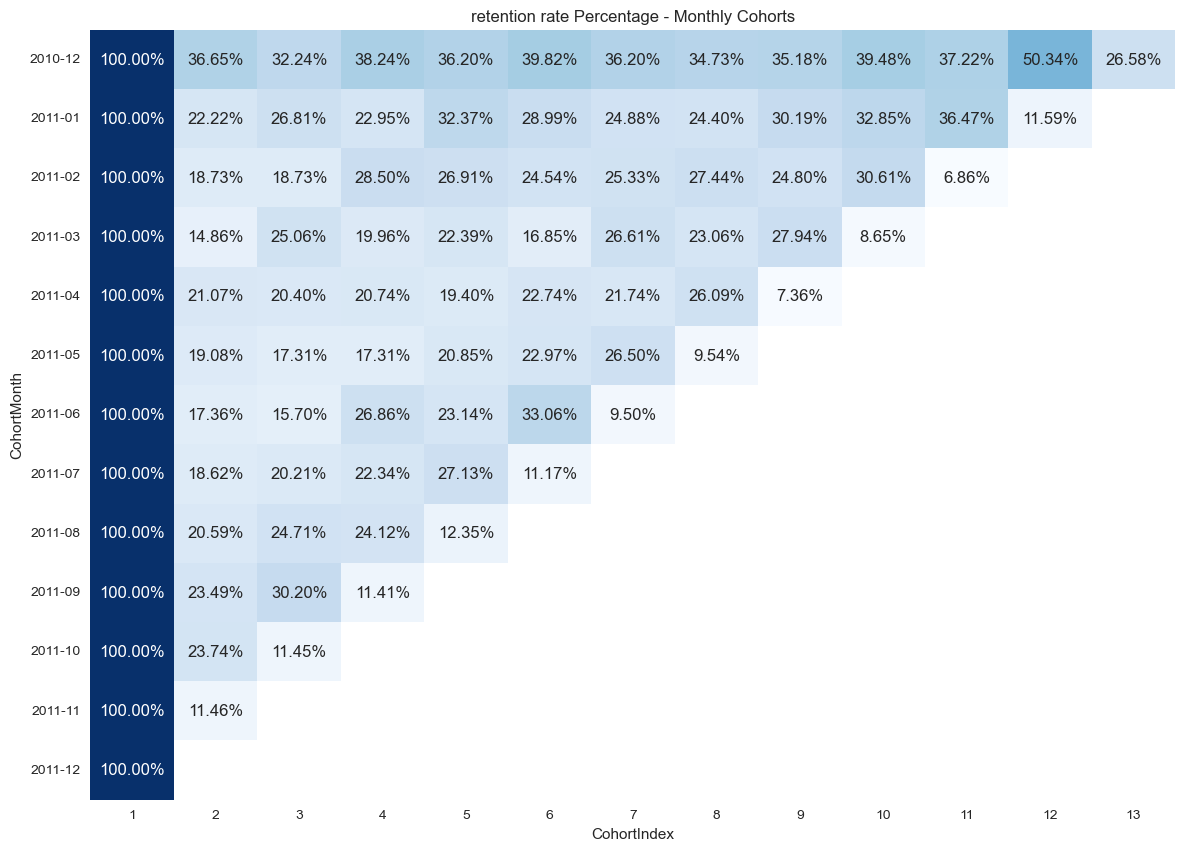

In [58]:
plt.rcParams['axes.facecolor'] ='white'
fig,ax =plt.subplots(figsize=(14,10))

sns.heatmap(retention, cmap ="Blues", annot = True, fmt =".2%", annot_kws ={"fontsize":12}, cbar=False, ax=ax)

plt.title("retention rate Percentage - Monthly Cohorts")
plt.yticks(rotation =0)
plt.show()

In [59]:
customer_per_month = df.groupby("CohortMonth")['CustomerID'].nunique().values
customer =customer_per_month.cumsum()
customers = customer[::-1]
customers

array([4330, 4289, 3966, 3608, 3310, 3140, 2952, 2710, 2427, 2128, 1677,
       1298,  884], dtype=int64)

In [60]:
customer_in_month = df.groupby("CohortIndex")['CustomerID'].nunique()
customer_in_month

CohortIndex
1     4330
2      975
3      939
4      924
5      902
6      875
7      802
8      721
9      678
10     640
11     506
12     493
13     235
Name: CustomerID, dtype: int64

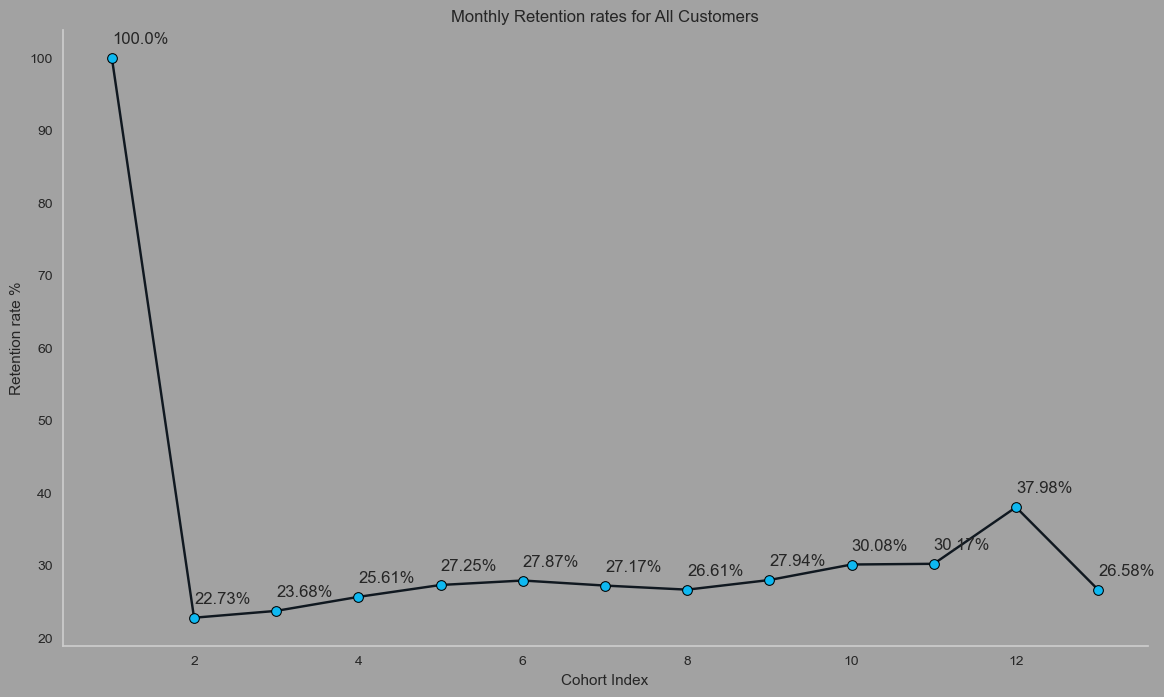

In [61]:
plt.rcParams['axes.facecolor'] = '#A2A2A2'
fig, ax =plt.subplots(figsize =(14,8), facecolor ="#A2A2A2")
ax.grid(False)
x =customer_in_month.index
y = 100*(customer_in_month/customers)

sns.lineplot( x =x, y =y, color ='#101820', marker ='o', markerfacecolor ='#0EB8F1', markeredgecolor = '#000000')

for x,y in zip(x,y):
    plt.text(x,y +2, s = str(round(y,2))+"%")
    
plt.xlabel("Cohort Index")
plt.ylabel('Retention rate %')
plt.title("Monthly Retention rates for All Customers")
sns.despine()
plt.show()

In [62]:
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})

monthly_customer_price_df

TotalPrice  CustomerID
InvoiceMonth                        
2010-12-01     560701.56         884
2011-01-01     561596.34         738
2011-02-01     441042.61         756
2011-03-01     581088.30         971
2011-04-01     453623.14         852
2011-05-01     659176.06        1053
2011-06-01     612357.84         989
2011-07-01     590787.94         945
2011-08-01     636901.73         934
2011-09-01     940865.31        1261
2011-10-01    1003860.91        1361
2011-11-01    1142426.97        1661
2011-12-01     514073.88         615

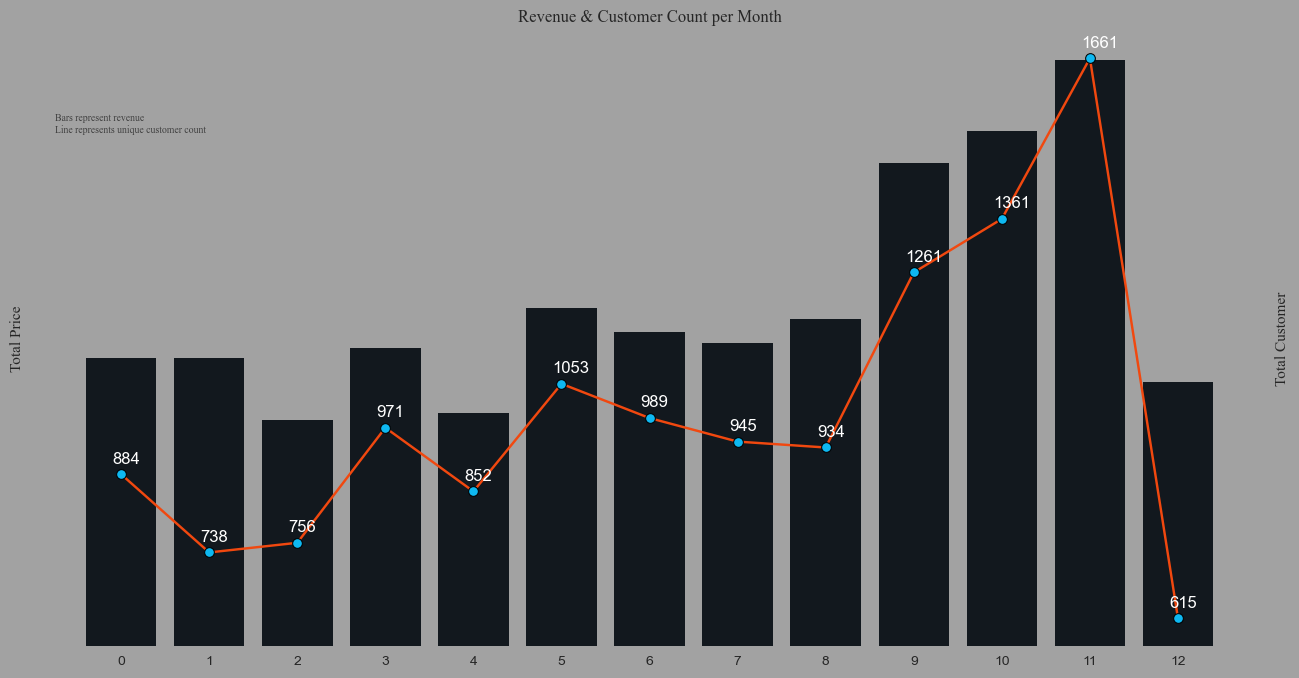

In [63]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

<a id='section-three'></a>

# 3) Pareto Principle

The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).

Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.

![](https://upload.wikimedia.org/wikipedia/commons/e/eb/Pareto_principle.png)

*https://en.wikipedia.org/wiki/Pareto_principle

**Let's implement Pareto's 80-20 rate to-our dataset**

 We have two hypothesis:
   1) 80% of company's revenue comes from 20% of total customer.
   2) 80% of company's revenue comes from 20% of total products.

**Sample Pareto Chart**

![](https://www.cec.health.nsw.gov.au/__data/assets/image/0005/341285/Pareto-1.png)

*https://www.cec.health.nsw.gov.au/Quality-Improvement-Academy/quality-improvement-tools/pareto-charts

**To check these hupothesis, we need only two things.**

 1. Individual sale records for customer/ product.
 2. Calculating cumulative sum for them.

I define below functions for calculation and visualization.

**prepare_pareto_data** finds individual per customer/product and calculation cumulative percentage of them.
**create_pareto_plot** takes output from thse data and visualize it.

In [64]:
def prepare_pareto_data(df,col,price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price,ascending =False)
    
    df_price ['CumulativePercentage'] = (df_price[price].cumsum()/df_price[price].sum()*100).round(2)
    
    return df_price

In [65]:
def create_pareto_plot(df, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

In [66]:
customer_price = prepare_pareto_data(df,"CustomerID", "TotalPrice")

customer_price.head(10)

TotalPrice  CumulativePercentage
CustomerID                                  
14646.0      279417.22                  3.21
18102.0      254279.92                  6.14
17450.0      194550.79                  8.37
16446.0      168472.50                 10.31
14911.0      135573.75                 11.87
12415.0      124564.53                 13.30
14156.0      115678.78                 14.63
17511.0       90831.98                 15.67
12346.0       77183.60                 16.56
16029.0       72882.09                 17.40

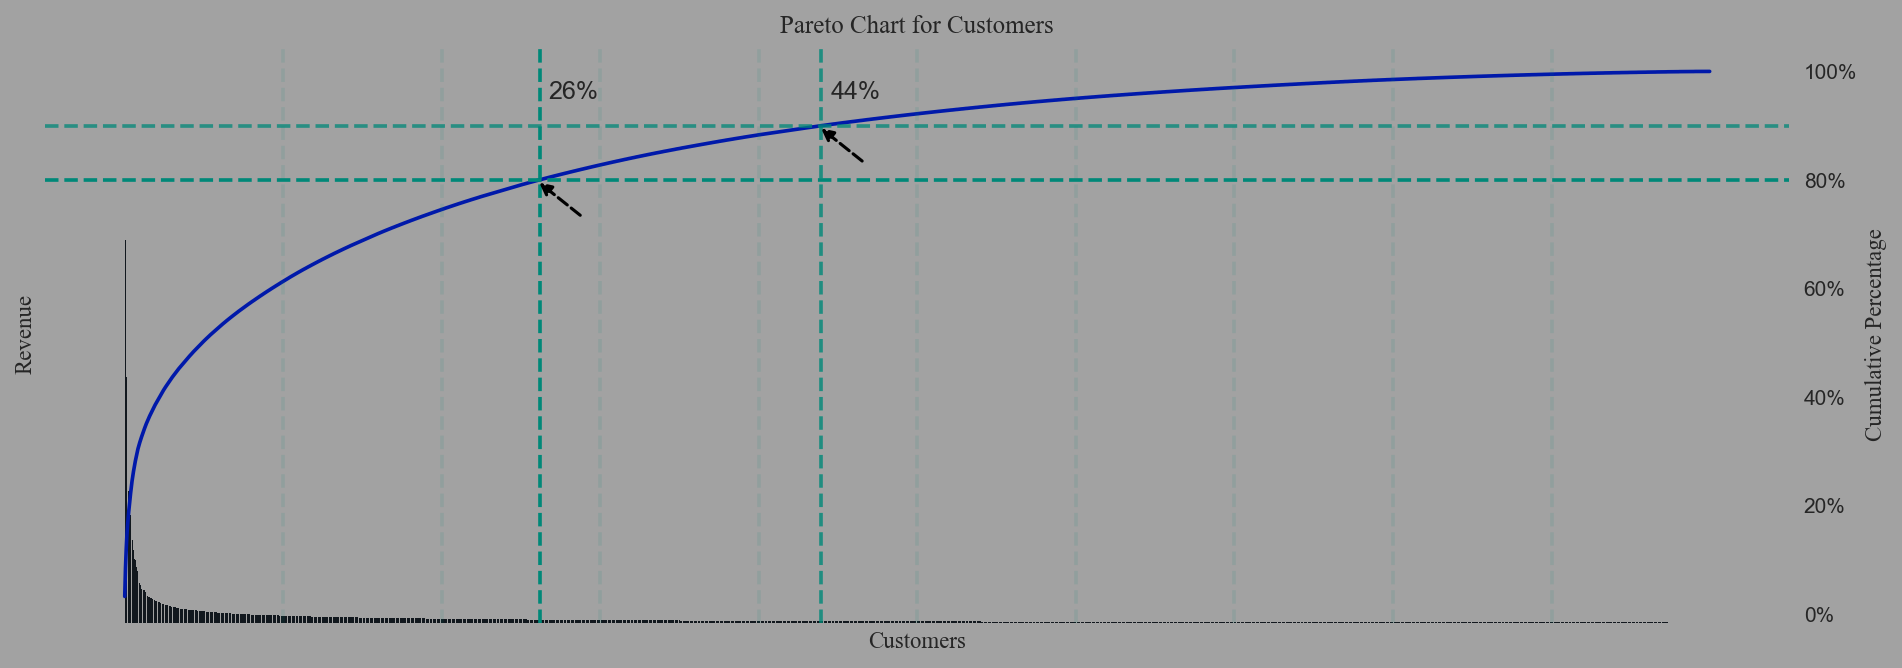

In [67]:
create_pareto_plot(customer_price,"CustomerID", "TotalPrice", log=False)

We can also plot it log scale . It help us for better visualization

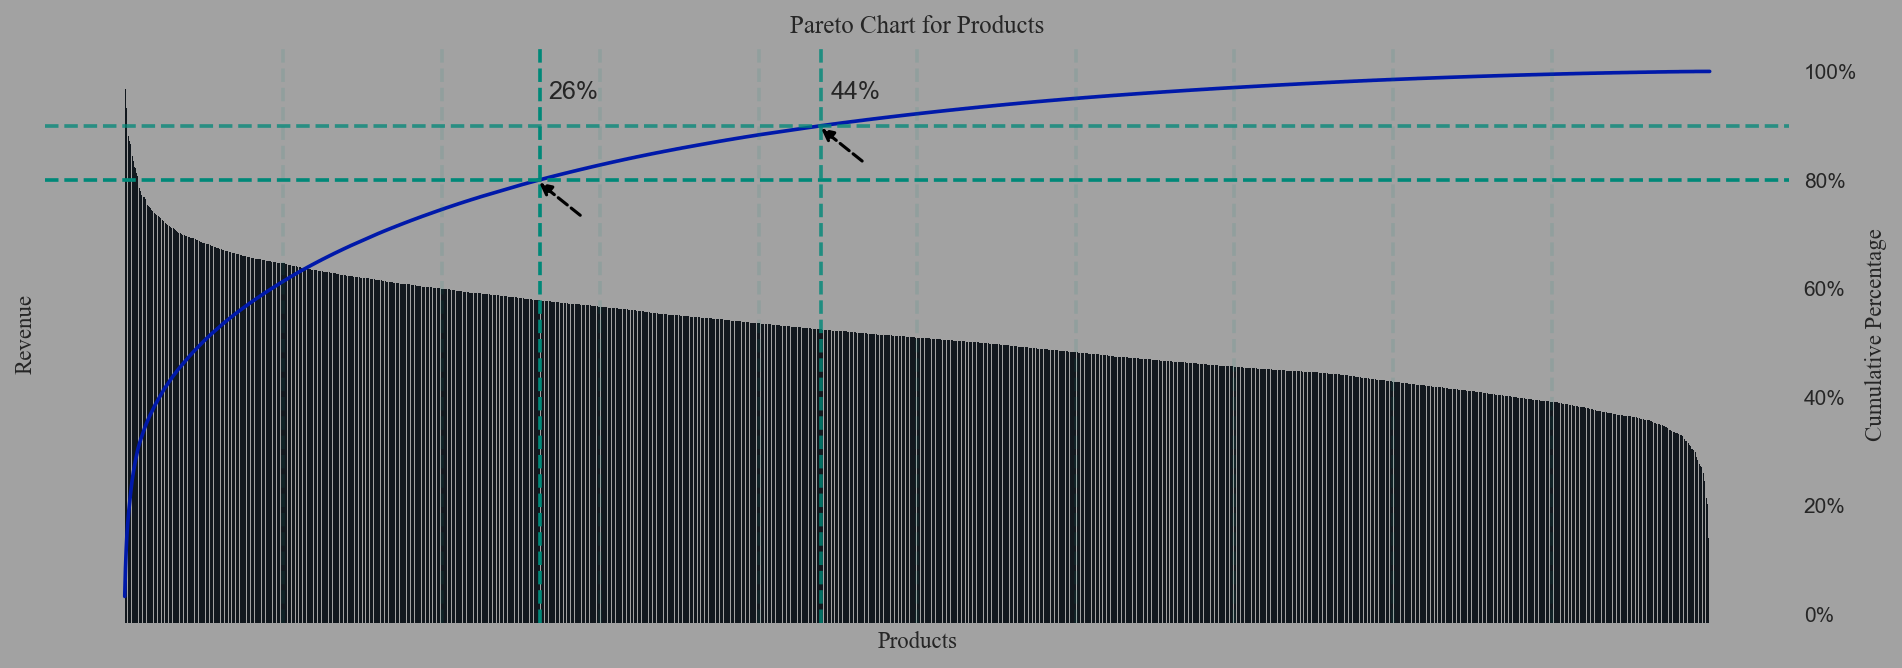

In [68]:
create_pareto_plot(customer_price,'customerID', "TotalPrice",log=True)

We, let's interpret these two charts. Actually, we don't need to write a lot of thing. We can see that 80% of company revenue comes from top 30% of customers.
Also, 90% of company revenue comes from top 48% customers.

## 3.2 Pareto Chart For Products

In [69]:
item_price = prepare_pareto_data(df,'StockCode',"TotalPrice")
item_price.head(10)

TotalPrice  CumulativePercentage
StockCode                                  
23843       168469.60                  1.94
22423       142218.55                  3.57
85123A      100603.50                  4.73
85099B       85220.78                  5.71
23166        81416.73                  6.64
47566        68844.33                  7.44
84879        56580.34                  8.09
23084        51346.20                  8.68
79321        46286.51                  9.21
22086        42660.83                  9.70

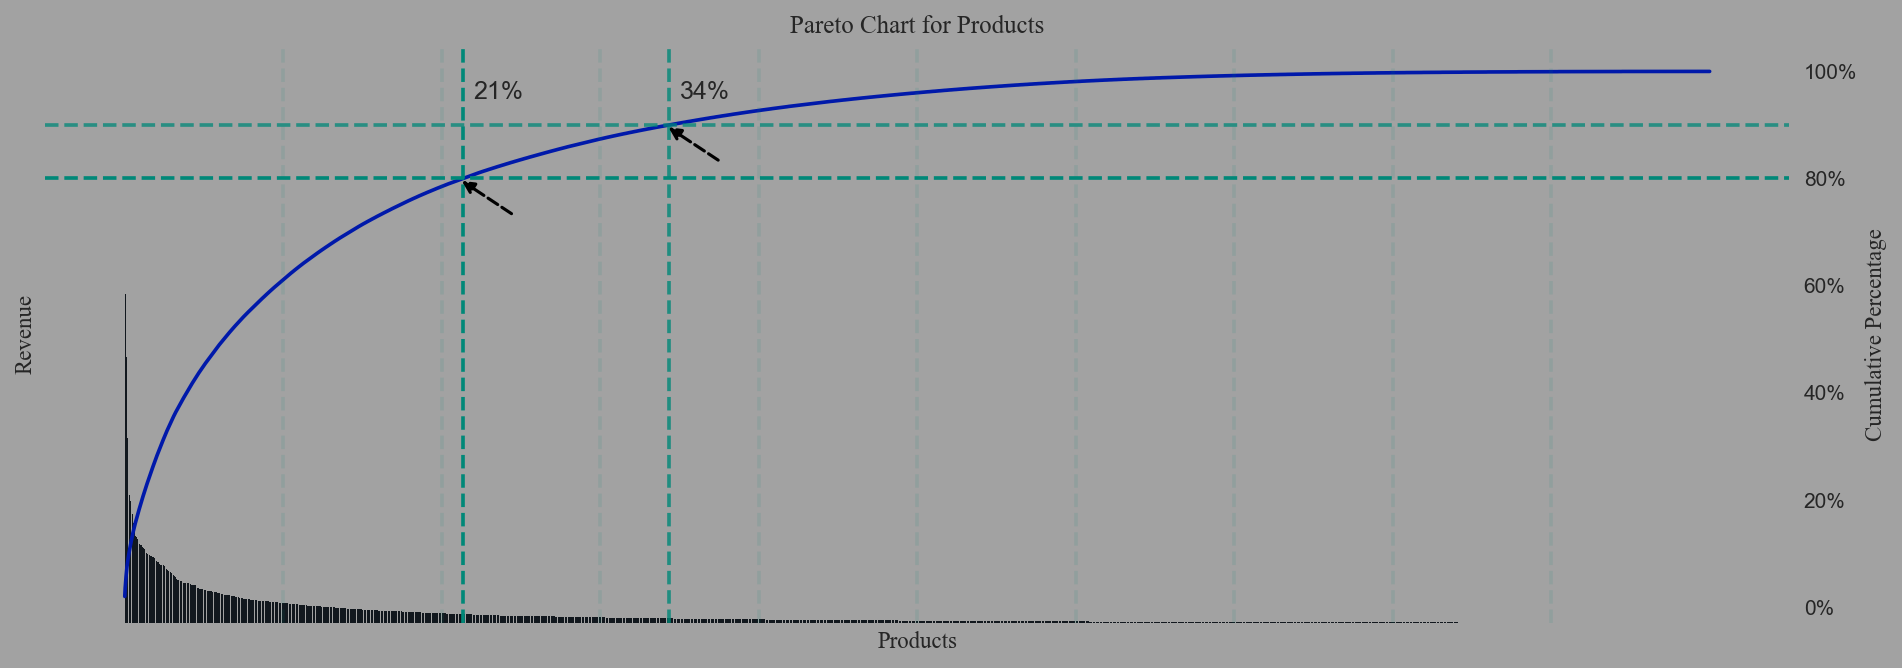

In [70]:
create_pareto_plot(item_price,'StockCode',"TotalPrice", log =False)

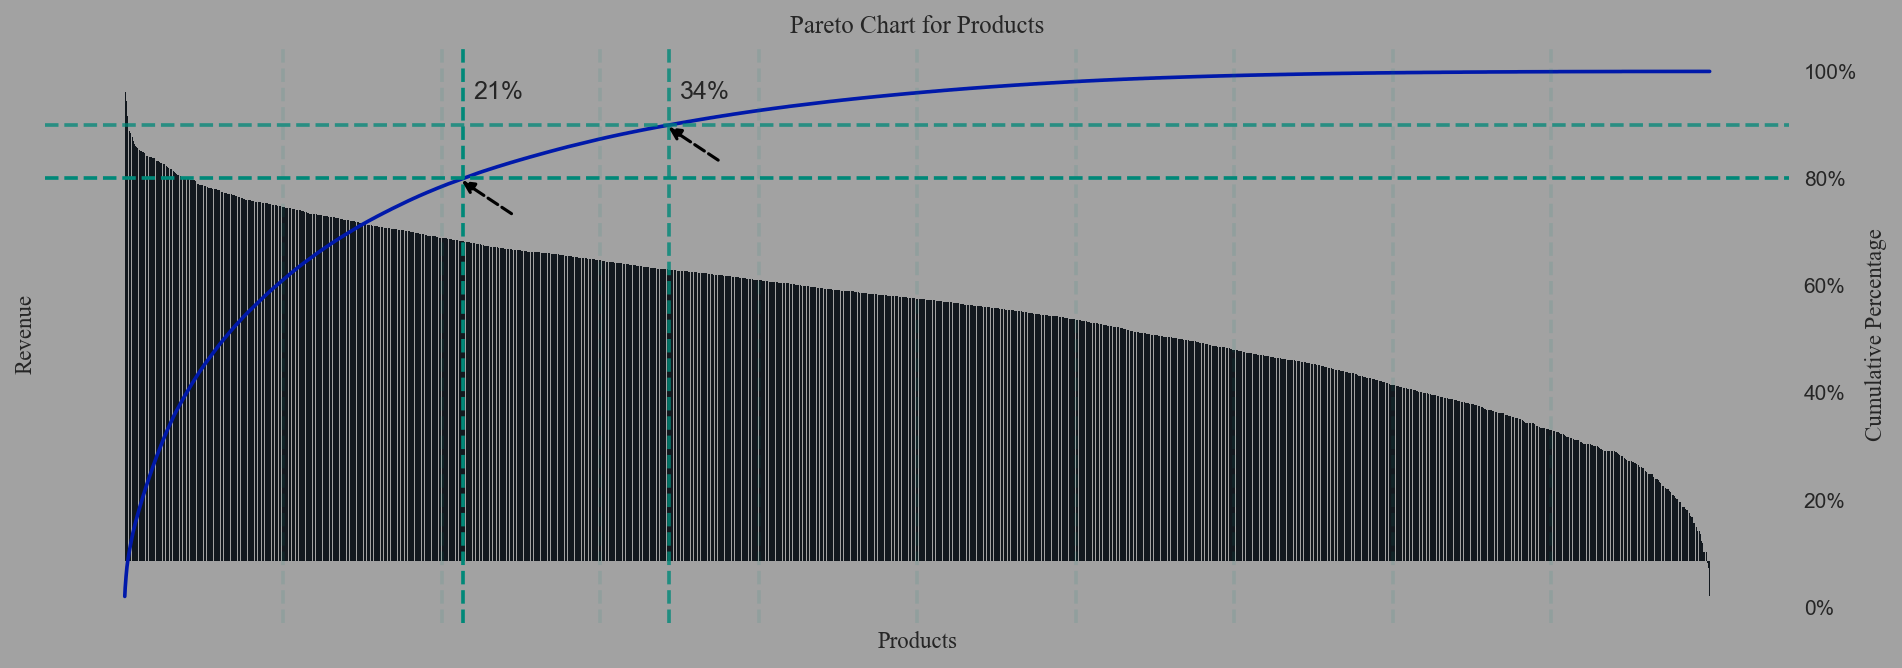

In [71]:
create_pareto_plot(item_price, 'StockCode',"TotalPrice")

We can see that 80% company revenue comes from top 23% of products that have most revenue.
Also, 90% of company revenues comes from 36% of product that have most revenue.
Maybe, if the company reduce by half variety, revenue couldn't decrese significantly.

In [72]:
top_customers = customer_price[customer_price.CumulativePercentage <=80].index.tolist()

products_for_top_customers =df[df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()
products_for_other_customers =df[~df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

## 4) RFM Analysis

Recency, frequency, monetary value í a maketing analysis tool used to identified a comnpany's or an organization best customers by using certain measures. The RFM model is based on three quantitative factors:

**Recency:** How recently a customer has made a purchase

**Frequancy:**  How often a cutomer makes a purchase

**Monetary:** Value How much money a customer spends on purchases


RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 ( the higher the number, the better the resuls). The "best" customer wwould receive a top score in every category.

*https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

![](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

*https://clevertap.com/blog/rfm-analysis/

Let's performance RFM Analysis on our data.

## 4.1) Preparing RMF Table

In [73]:
print("Min date :{} \n Max date:{}".format(df.InvoiceDate.min(),df.InvoiceDate.max()))

Min date :2010-12-01 08:26:00 
 Max date:2011-12-09 12:50:00


In [74]:
last_day =df.InvoiceDate.max()+ dt.timedelta(days=1)


In [75]:
# group InvoiceDate, InvoiceNo, TotalPrice in DataFrame
rfm_table =df.groupby("CustomerID").agg({'InvoiceDate': lambda x : (last_day - x.max()).days,
                                        "InvoiceNo":"nunique",
                                        "TotalPrice":"sum"})

In [76]:
rfm_table.rename(columns={'InvoiceDate':"Recency",
                         "InvoiceNo":"Frequency",
                         "TotalPrice":"Monetary"}, inplace=True)
rfm_table.head()

Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1437.24
12349.0          19          1   1417.60
12350.0         310          1    294.40

In [77]:
r_labels = range(5,0,-1)
fm_labels = range(1,6)

rfm_table['R'] = pd.qcut(rfm_table['Recency'], 5, labels =r_labels)
rfm_table['F'] = pd.qcut(rfm_table['Frequency'].rank(method ='first'),5,labels=fm_labels)
rfm_table['M'] = pd.qcut(rfm_table["Monetary"],5,labels =fm_labels)

rfm_table.head()

Recency  Frequency  Monetary  R  F  M
CustomerID                                       
12346.0         326          1  77183.60  1  1  5
12347.0           2          7   4310.00  5  5  5
12348.0          75          4   1437.24  2  4  4
12349.0          19          1   1417.60  4  1  4
12350.0         310          1    294.40  1  1  2

In [78]:
# filter value 
rfm_table['RFM_Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str) + rfm_table['M'].astype(str)
rfm_table['RFM_Scorte'] = rfm_table[['R','F','M']].sum(axis =1)

rfm_table.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Scorte
CustomerID                                                               
12346.0         326          1  77183.60  1  1  5         115           7
12347.0           2          7   4310.00  5  5  5         555          15
12348.0          75          4   1437.24  2  4  4         244          10
12349.0          19          1   1417.60  4  1  4         414           9
12350.0         310          1    294.40  1  1  2         112           4

**Champions:** Bought recently, buy often and spend the most
    
**Loyal customers:** Buy on a regular basis.Responsive to promations.

**Potential loyalist:** Bought most recently, but not often.

**Promissing:** recent shoppers, but haven't spent much.

**Needs attention:** Above aberage recency, frequency and monetary values. May not have bought very recently through.

**About to sleep:** Below average recency and frequanecy. Will lose them if not reactivvated.

**At risk:** Some time since they're purchased. Need to bring them back!

**Can't lose them:** Used to purchase frequently but haven't returned for a long time.

**Hibernating:** Last purchase was long back and low number of orders. May be lost.

*https://futurice.com/blog/know-your-customers-with-rfm

I don't know is it right source of below segmentation map dict, but I found that code here. https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [79]:
segt_map={
    r"[1-2][1-2]":"Hibernating",
    r'[1-2][3-4]': "At- Risk",
    r'[1-2]5': "Cannot lose them",
    r'3[1-2]':"About To Sleep",
    r"33":"Need Attention",
    r'[3-4][4-5]':'Loyal Customer',
    r'41':"Promising",
    r'51':"New Customers",
    r'[4-5][2-3]':"Potential Loyalists",
    r'5[4-5]':"Champions"}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map,regex=True)
rfm_table.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Scorte  \
CustomerID                                                                  
12346.0         326          1  77183.60  1  1  5         115           7   
12347.0           2          7   4310.00  5  5  5         555          15   
12348.0          75          4   1437.24  2  4  4         244          10   
12349.0          19          1   1417.60  4  1  4         414           9   
12350.0         310          1    294.40  1  1  2         112           4   

                Segment  
CustomerID               
12346.0     Hibernating  
12347.0       Champions  
12348.0        At- Risk  
12349.0       Promising  
12350.0     Hibernating

## 4.3) Visualizing RFM Grid

![](https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg)

*https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg

Well, I'm surprised name plot above graph
I wrote these codes for visualize above RFM grid

In [80]:
rfm_coordinates = {"Champions":[3,5,0.8,1],
                  "Loyal Customers": [3,5,0.4,0.8],
                  "Cannot lose them": [4,5,0,0.4],
                  "At-Risk":[2,4,0,0.4],
                  "Hibernating": [0,2,0,0.4],
                  "About To Sleep": [0,2,0.4,0.6],
                  'Promising':[0,1,0.6,0.8],
                  'New Customers': [0,1,0.8,1],
                  "Need Attention": [2,3,0.4,0.6]}

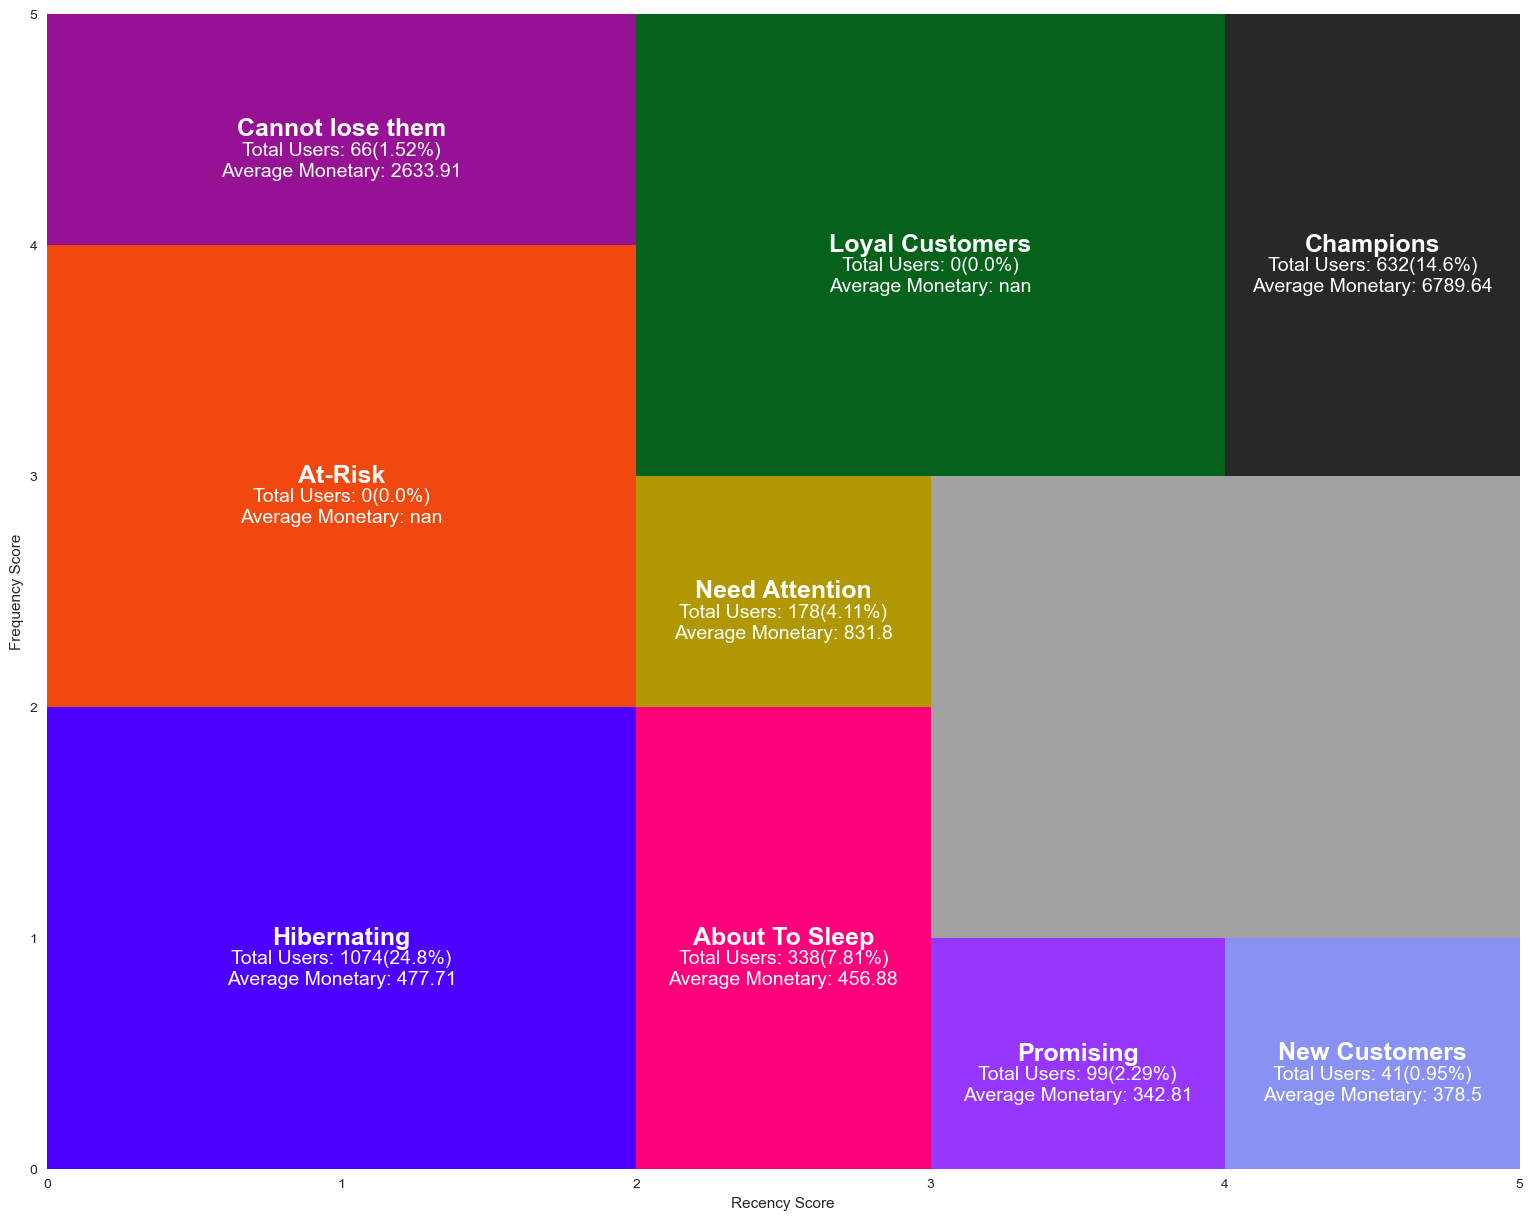

In [81]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]
for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0]/ rfm_table.shape[0])*100
    avg_monetary = rfm_table[rfm_table.Segment == key]['Monetary'].mean()
    
    user_txt = "\n\nTotal Users: "+ str(users) + "(" + str(round(users_percentage,2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary,2))
    
    x = 5*(xmin + xmax)/2
    y = (ymin + ymax)/2
    
    plt.text(x = x, y = y, s= key, ha= "center", va='center',fontsize = 18, color ='white', fontweight ='bold')
    plt.text(x = x, y = y, s= user_txt, ha='center', va='center', fontsize = 14, color='white' )
    plt.text(x = x, y = y, s = monetary_txt, ha='center', va='center', fontsize = 14, color ='white')
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom =True)
plt.show()
    

## 4.4) Visualizing RFM Segments

We can show table of descriptive statistics for RFM segments, but it is not bet way. Using data visualization and creating greate plots as important as finding freate results.

In [82]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

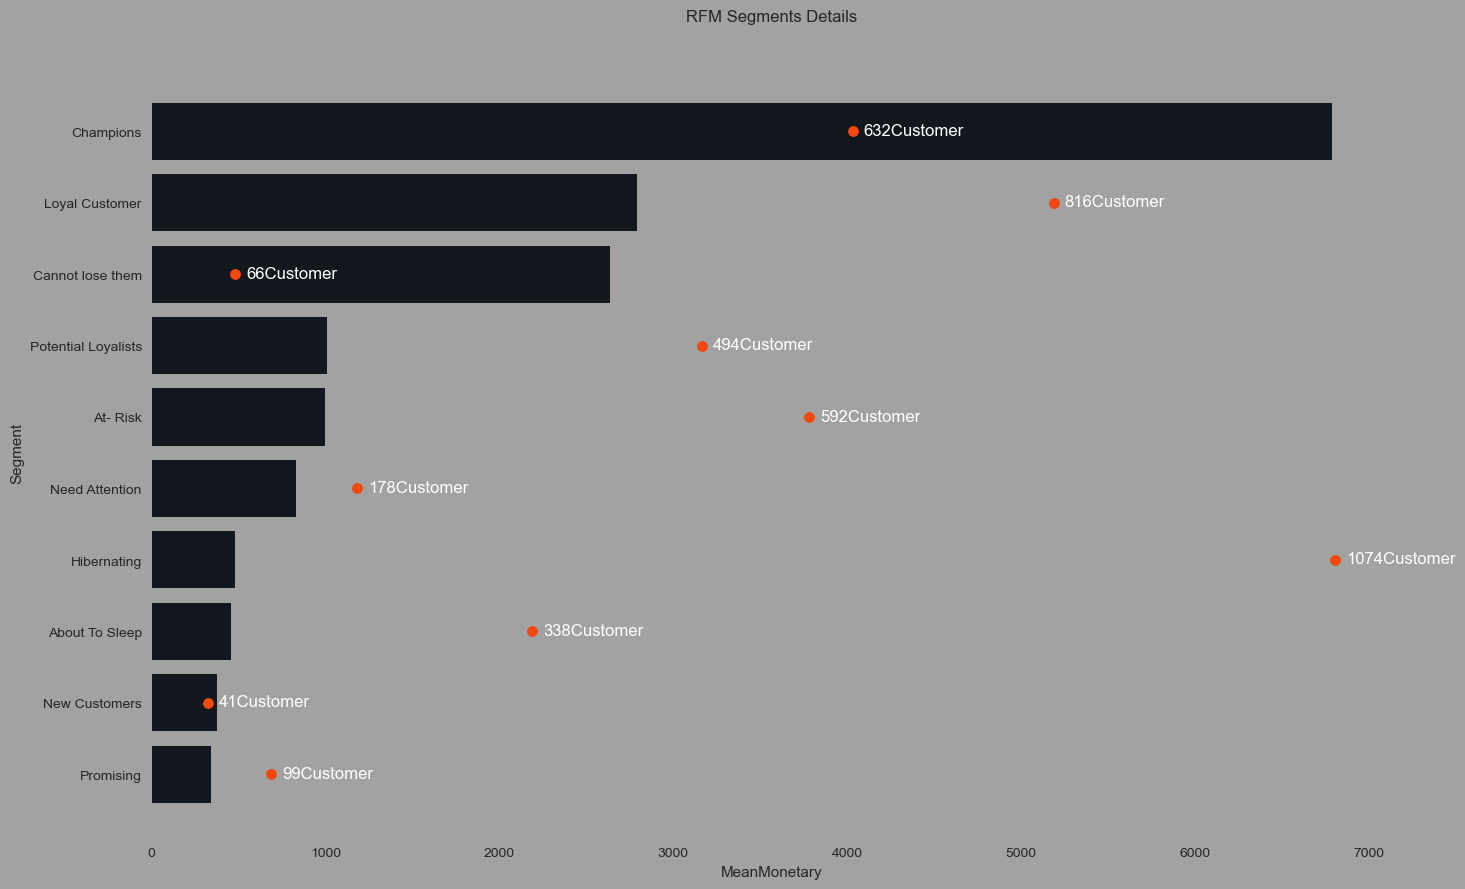

In [83]:
# Bar chart count of number each segment customer by RFM Score
plt.rcParams['axes.facecolor'] = '#A2A2A2'
fig, ax = plt.subplots(figsize =(16,10), facecolor ='#A2A2A2')

sns.barplot(x =rfm_monetary_size.MeanMonetary, y =rfm_monetary_size.index, ax=ax, color='#101820')
ax2 = ax.twiny()
sns.lineplot( x = rfm_monetary_size.CustomerCount, y =rfm_monetary_size.index, ax=ax2, marker='o',linewidth =0,
            color ='#F1480F', markeredgecolor ='#F1480F')

ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x+10 , y+ 0.05, str(x) + 'Customer', color ='white', fontweight ='normal')

plt.title("RFM Segments Details")
sns.despine(left = True, bottom = True, top = True)
plt.show()


In [84]:
rfm =rfm_table2.groupby("Segment").agg({'CustomerID': 'nunique',
                                       'Recency':'mean',
                                       'Frequency':'mean',
                                       'Monetary':'mean'})
rfm.rename(columns = {'CustomerID': 'Segment Size'}, inplace =True)

cm =sns.light_palette("#A2A2A2", as_cmap =True)

rfm.T.style.background_gradient(cmap =cm, axis =1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis =1, color ='#D60000')



C:\Users\DeLL\AppData\Local\Temp\ipykernel_9112\2584710741.py:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  rfm.T.style.background_gradient(cmap =cm, axis =1)\


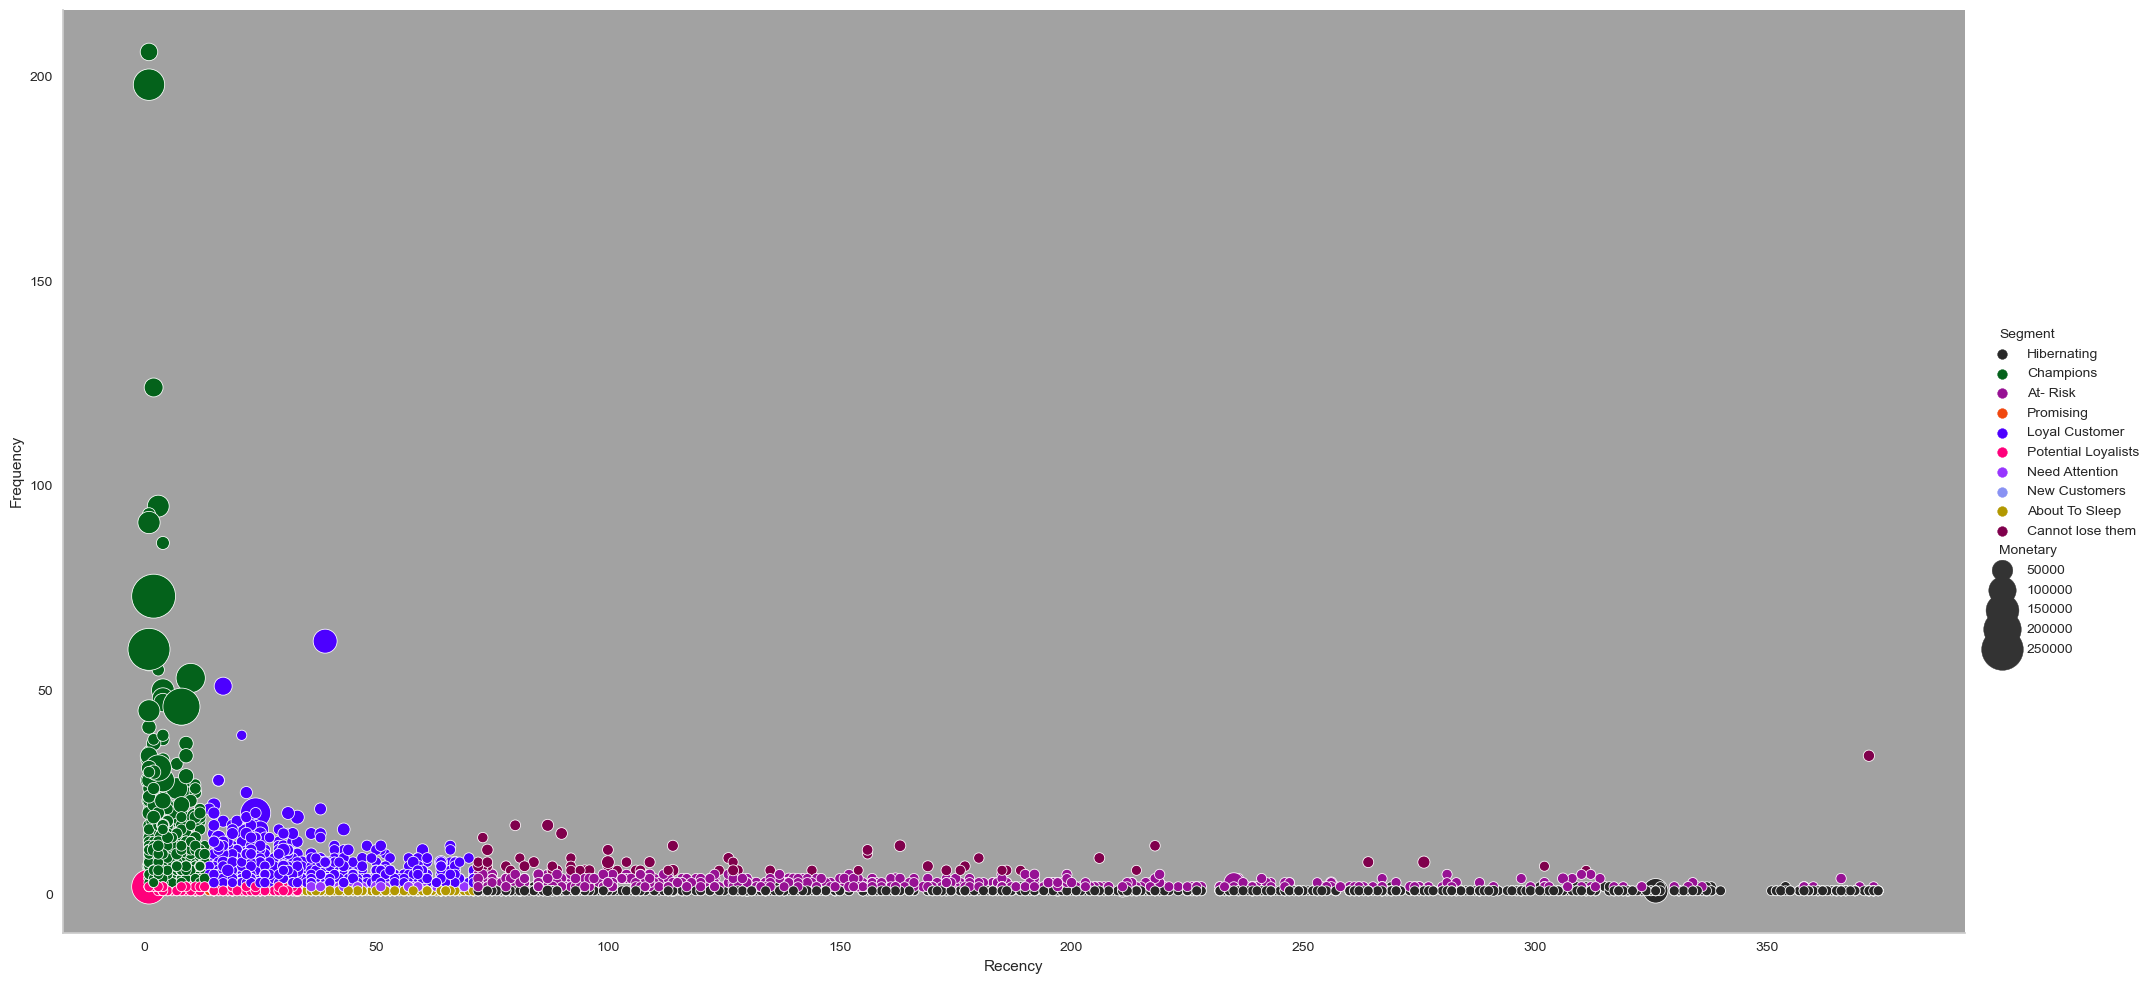

In [85]:
plt.rcParams['axes.facecolor'] ='#A2A2A2'
plt.rcParams['axes.grid'] = False

sns.relplot( x ='Recency', y ='Frequency', hue ='Segment', size ='Monetary', data =rfm_table2, palette = palette,
            height = 10 , aspect = 2, sizes = (50,1000))
plt.show()


In [86]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

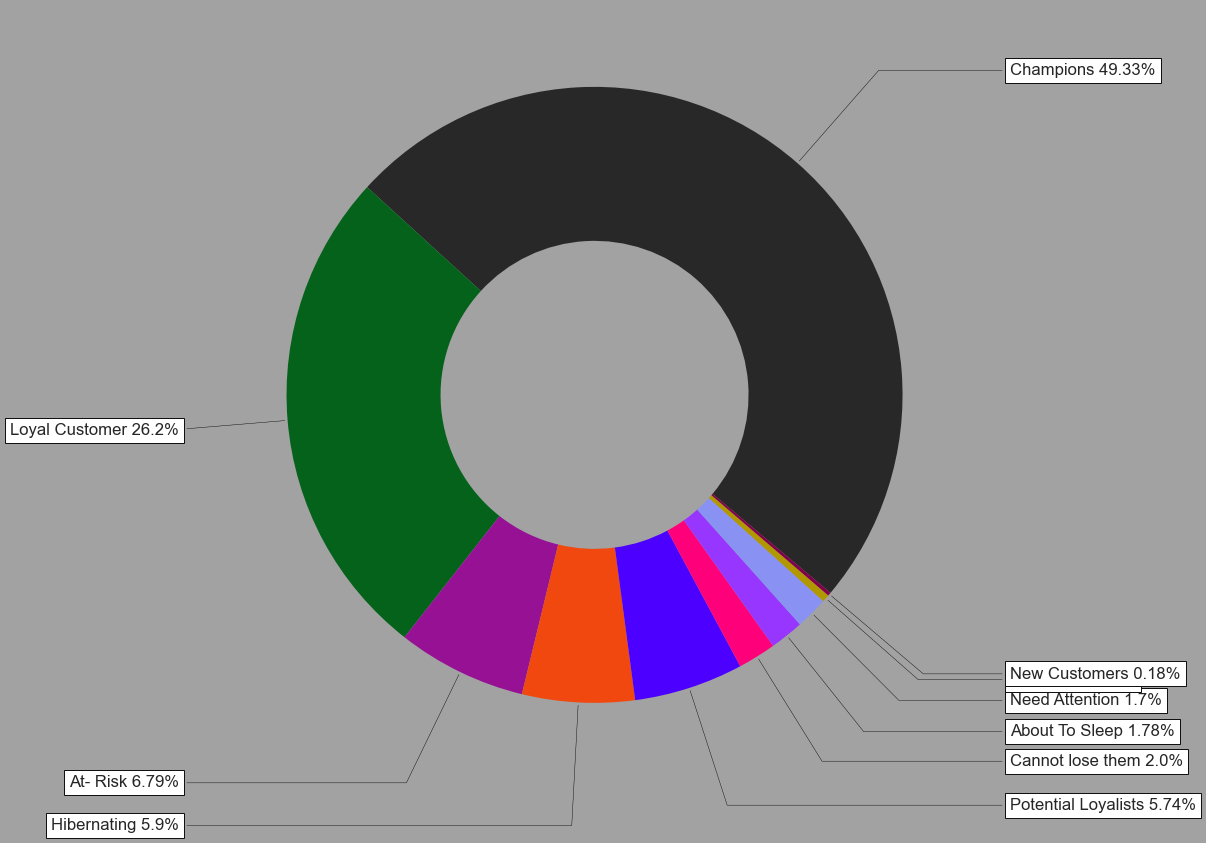

In [87]:
fig, ax = plt.subplots(figsize=(10,10), facecolor ="#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops = dict(width= 0.5),
                       startangle = -40, normalize=False, colors =palette)
bbox_props =dict(boxstyle ="square, pad = 0.3", fc ="w", ec ='k', lw= 0.72)
kw = dict(arrowprops = dict(arrowstyle ='-'),
         bbox =bbox_props, zorder =0, va ='center')
for i,p in enumerate (wedges):
    ang = (p.theta2 - p.theta1)/2.+ p.theta1
    y = np.sin(np.deg2rad(ang))
    x =np.cos(np.deg2rad(ang))
    horizontalalignment ={-1: "right",1:"left"} [int(np.sign(x))]
    connectionstyle = "angle, angle A=0, angleB={}".format(ang)
    kw['arrowprops'].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i]+" "+ str(round(monetary_per_segment[i]*100,2))+ "%", xy=(x,y),
                xytext =(1.35*np.sign(x),1.4*y), horizontalalignment = horizontalalignment, **kw)

plt.show()

In [88]:
rfm_clustering =rfm_table2[['Recency','Frequency','Monetary','Segment']]
for col in ['Recency', 'Frequency', "Monetary"]:
    scaler =  StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1,1))

rfm_melted = pd.melt(rfm_clustering, id_vars ="Segment", value_vars=['Recency',"Frequency",'Monetary'],
                    var_name ="RFM", value_name="Value")

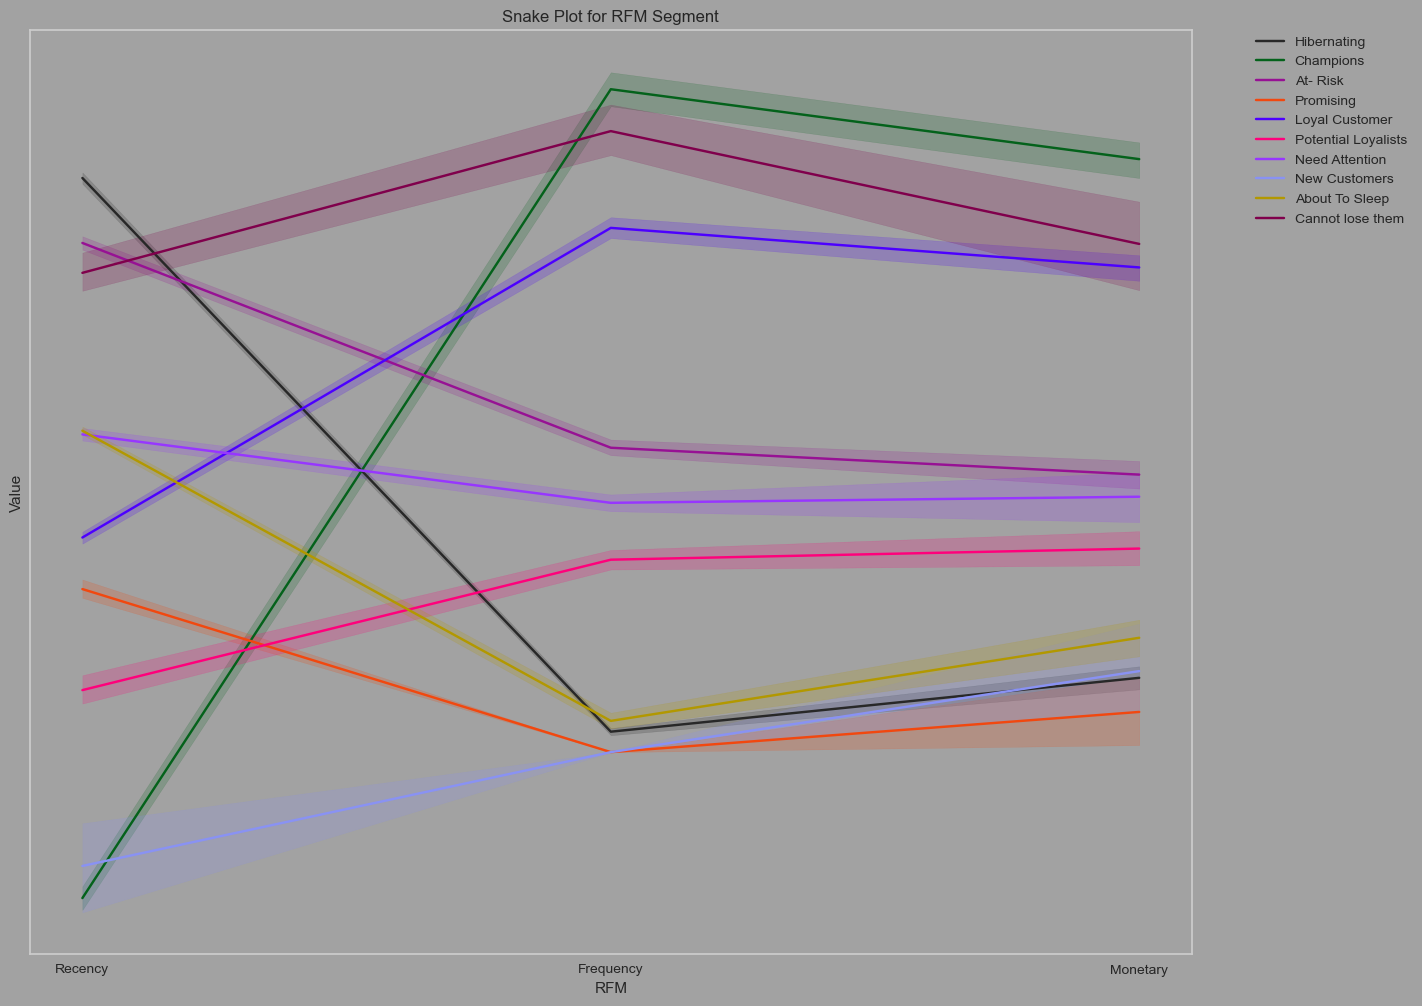

In [89]:
fig, ax =plt.subplots(figsize =(15,12), facecolor ='#A2A2A2')
ax.set_facecolor("#A2A2A2")

sns.lineplot(x="RFM", y='Value', hue='Segment', data =rfm_melted, palette =palette)
ax.legend(bbox_to_anchor = (1.05,1), loc=2,borderaxespad =0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segment")
plt.show()


## 4.5) Cutomer Segmentation with using RFM Metrics

C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_k

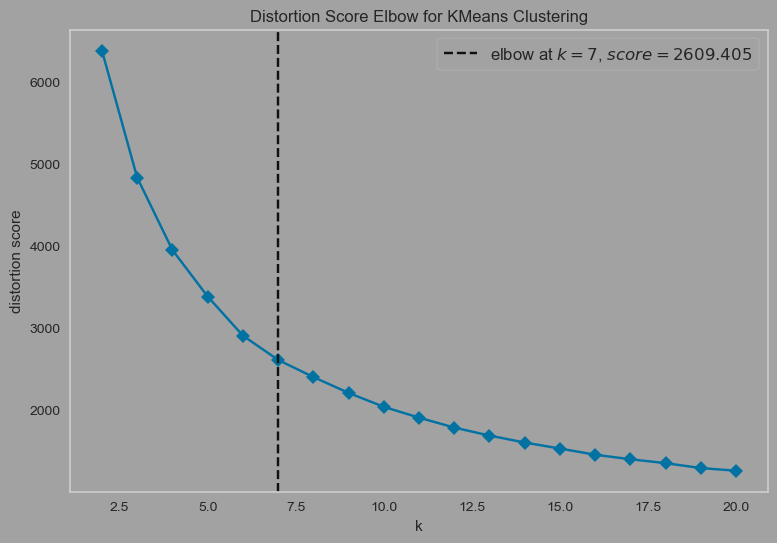

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
features = ['Recency','Frequency','Monetary']

kmeans = KMeans(init ='k-means++', random_state =42)

fig,ax = plt.subplots(figsize = (9,6), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")
ax.grid(False)

visualizer =KElbowVisualizer(kmeans, k=(2,21),timings =False)

visualizer.fit(rfm_clustering[features])
visualizer.show()

C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


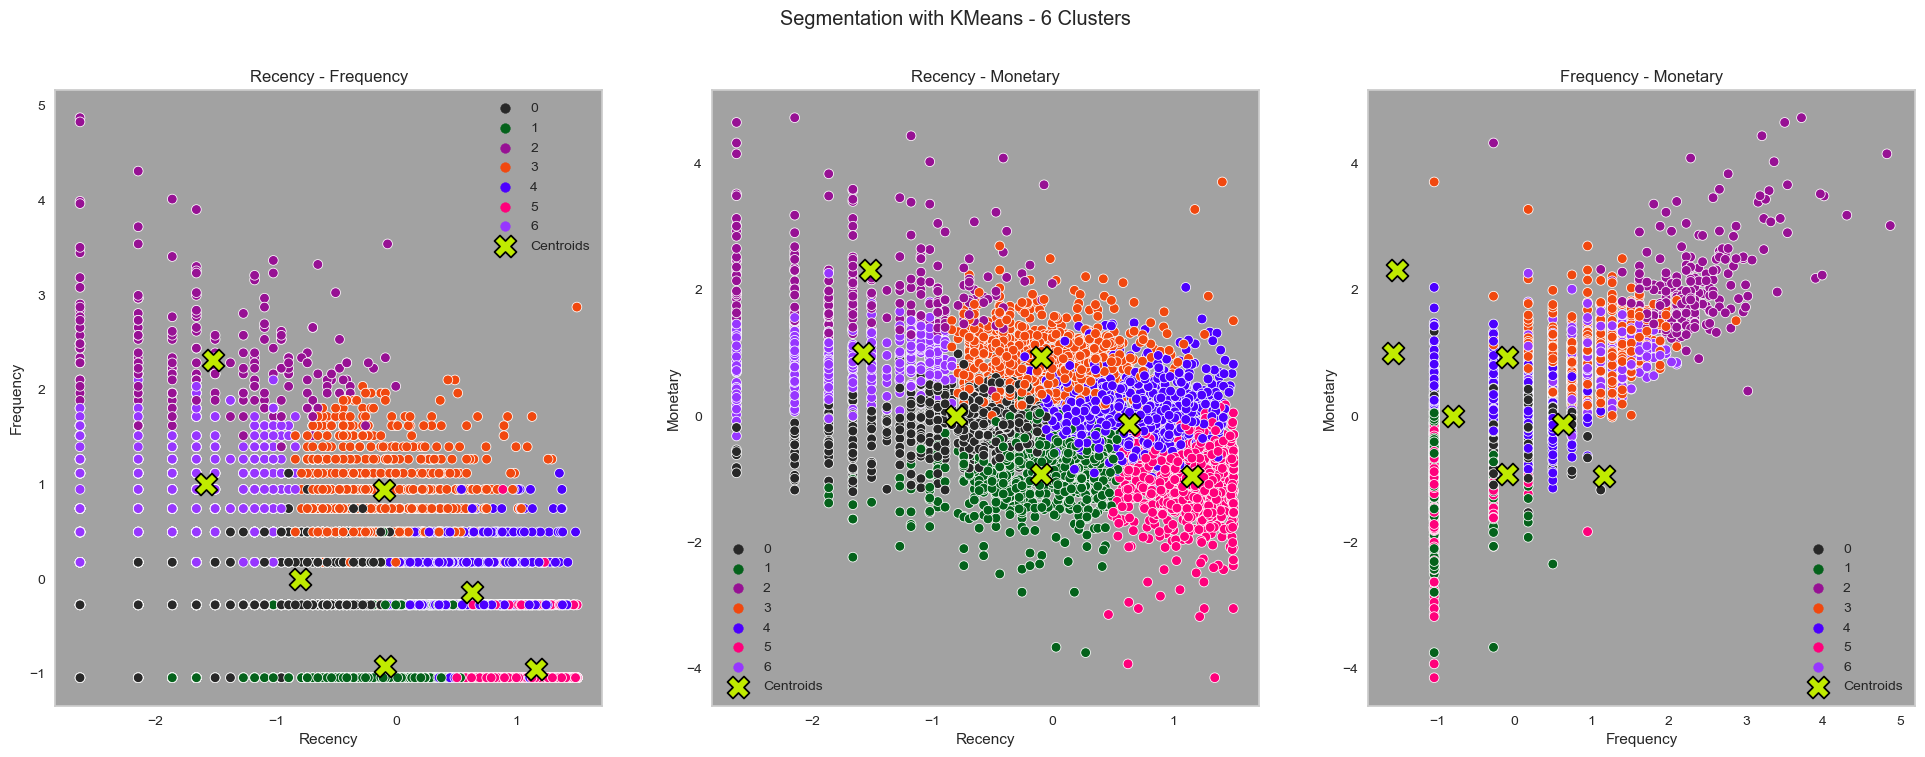

In [91]:
kmeans =KMeans(n_clusters =7, random_state=42)
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_

fig,axes = plt.subplots(1,3, figsize = (24,8))
for i, feature in  list(enumerate(combinations(['Recency','Frequency','Monetary'],2))):
    
    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue =cluster,
                   palette = palette[:len(set(cluster))], ax = axes[i]).set_title(feature[0]+" - "+feature[1])
    
    sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1],
                   s = 250, color ="#C0EB00", label ='Centroids', marker = 'X', ax =axes[i], edgecolor ='black')
plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.grid(False)

plt.show()

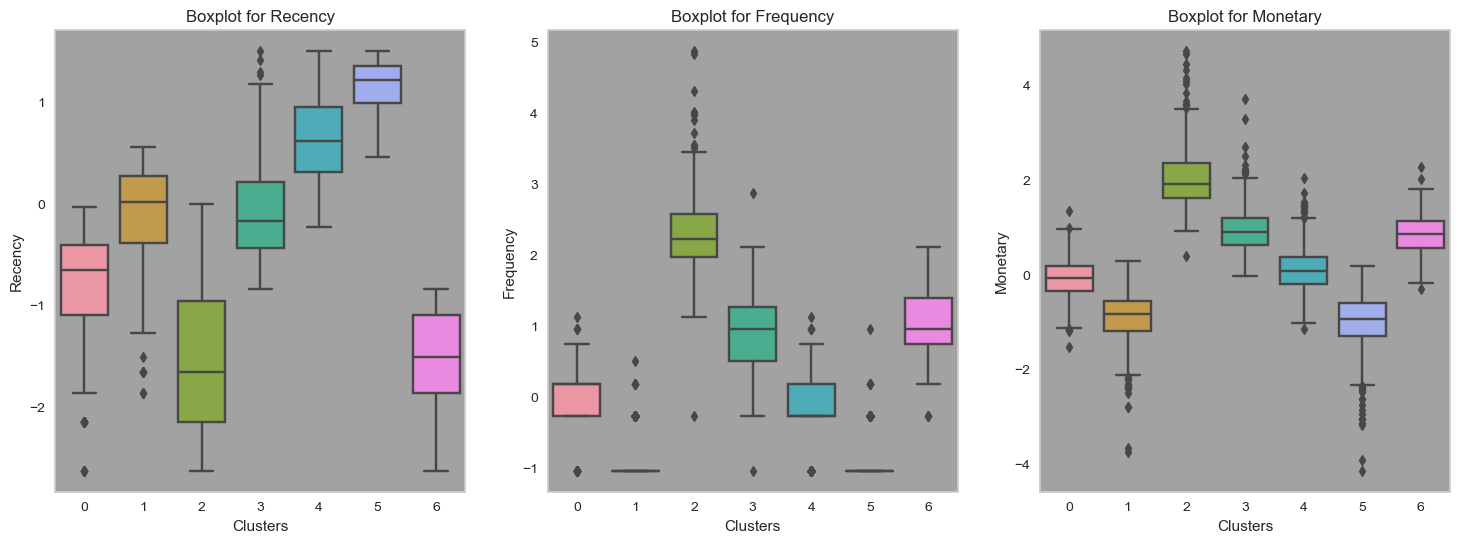

In [92]:
fig, axes = plt.subplots(1,3, figsize = (18,6))

for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.set_xlabel("Clusters")
    
sns.boxplot( x = cluster, y ='Recency', data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency")
sns.boxplot(x = cluster, y ="Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency")
sns.boxplot(x = cluster, y ='Monetary', data = rfm_clustering, ax= axes[2]).set_title("Boxplot for Monetary")

plt.show()

In [93]:
plt.rcdefaults()

## 5) Forecasting with Prophet

In [94]:
df =pd.read_csv("C:\\Users\\DeLL\\Python_school\\practice\\completed\\Online_retail_final.csv",encoding = 'unicode_escape')
display(df.head())

print(df.shape)

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   white hanging heart t-light holder         6   
1     536365     71053                  white metal lantern         6   
2     536365    84406B       cream cupid hearts coat hanger         8   
3     536365    84029G  knitted union flag hot water bottle         6   
4     536365    84029E       red woolly hottie white heart.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

(393806, 9)


## 5.1) Data Prepraration For Time Series

In [95]:
df = df[df.Country == 'United Kingdom']

In [96]:
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df.loc[:, 'InvoiceDate'])

print(f"First observation on data is {df.InvoiceDate.min()}")
print(f"Last observation on data is {df.InvoiceDate.max()}")

print(f'We have {(df.InvoiceDate.max() - df.InvoiceDate.min()).days} days.')

First observation on data is 2010-12-01 08:26:00
Last observation on data is 2011-12-09 12:49:00
We have 373 days.


C:\Users\DeLL\AppData\Local\Temp\ipykernel_9112\1099847411.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'InvoiceDate'] = pd.to_datetime(df.loc[:, 'InvoiceDate'])


- We have 0 days sales record. Daily data can be more suitable.

In [97]:
df.set_index("InvoiceDate", inplace =True)
df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                                     
2010-12-01 08:26:00     536365    85123A   white hanging heart t-light holder   
2010-12-01 08:26:00     536365     71053                  white metal lantern   
2010-12-01 08:26:00     536365    84406B       cream cupid hearts coat hanger   
2010-12-01 08:26:00     536365    84029G  knitted union flag hot water bottle   
2010-12-01 08:26:00     536365    84029E       red woolly hottie white heart.   

                     Quantity  UnitPrice  CustomerID         Country  \
InvoiceDate                                                            
2010-12-01 08:26:00         6       2.55     17850.0  United Kingdom   
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom   
2010-12-01 08:26:00         8       2.75     17850.0  United Kingdom   
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom   
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom   

                     TotalPrice  
InvoiceDate                      
2010-12-01 08:26:00       15.30  
2010-12-01 08:26:00       20.34  
2010-12-01 08:26:00       22.00  
2010-12-01 08:26:00       20.34  
2010-12-01 08:26:00       20.34

## 5.1.1) Weekly

In [98]:
prices_df = pd.DataFrame(df.groupby("InvoiceDate").TotalPrice.sum())
prices_df = prices_df.iloc[:-1]
prices_df

TotalPrice
InvoiceDate                    
2010-12-01 08:26:00      139.12
2010-12-01 08:28:00       22.20
2010-12-01 08:34:00      348.78
2010-12-01 08:35:00       17.85
2010-12-01 09:00:00      204.00
...                         ...
2011-12-09 12:20:00      145.29
2011-12-09 12:21:00       29.88
2011-12-09 12:23:00      124.60
2011-12-09 12:25:00      140.64
2011-12-09 12:31:00      329.05

[15298 rows x 1 columns]

**Convert Total Price on Week**

In [99]:
weekly_prices = prices_df.resample("W").sum()
weekly_prices.head()

TotalPrice
InvoiceDate            
2010-12-05    118160.93
2010-12-12    145229.35
2010-12-19    127916.51
2010-12-26     27722.48
2011-01-02         0.00

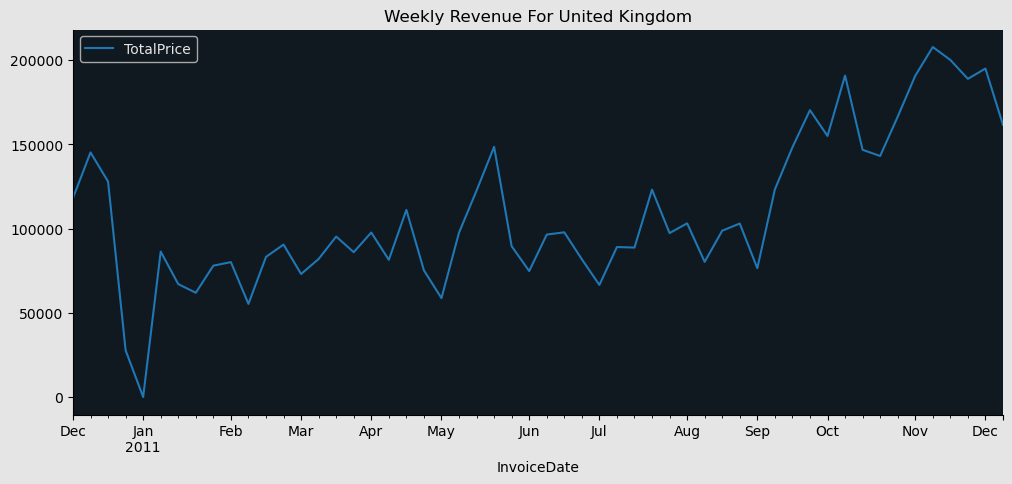

In [100]:
fig,ax = plt.subplots(figsize =(12,5), facecolor="#e5e5e5")
ax.set_facecolor("#101820")

weekly_prices.plot( ax=ax).set_title("Weekly Revenue For United Kingdom")
ax.legend(facecolor = "#101820", labelcolor ="#e5e5e5")

sns.despine()
plt.show()

Her, we have revenue per week graph. Let's interpret it.
Ealier January, this retailer was closed. Revenue is 0.
We see first speak in the Middle of May.
Second peak is in the begining of October.
The revenue top out in the middle of November.

## 5.1.2) Daily Data

I just convert data to daily from wwith using resample method. Let's dive in.


In [101]:
daily_sales = pd.DataFrame(df.groupby("InvoiceDate").sum().resample("D").sum()["TotalPrice"])
daily_sales

C:\Users\DeLL\AppData\Local\Temp\ipykernel_9112\990920502.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_sales = pd.DataFrame(df.groupby("InvoiceDate").sum().resample("D").sum()["TotalPrice"])


TotalPrice
InvoiceDate            
2010-12-01     34683.15
2010-12-02     40713.98
2010-12-03     17918.34
2010-12-04         0.00
2010-12-05     24845.46
...                 ...
2011-12-05     45549.18
2011-12-06     38430.04
2011-12-07     31117.15
2011-12-08     35815.07
2011-12-09     11058.98

[374 rows x 1 columns]

We saw that there is a zore revenue week in earlier January

In [102]:
daily_sales.loc["2010-12-23":"2011-01-04"]

TotalPrice
InvoiceDate            
2010-12-23      3967.57
2010-12-24         0.00
2010-12-25         0.00
2010-12-26         0.00
2010-12-27         0.00
2010-12-28         0.00
2010-12-29         0.00
2010-12-30         0.00
2010-12-31         0.00
2011-01-01         0.00
2011-01-02         0.00
2011-01-03         0.00
2011-01-04     11541.42

In [103]:
daily_sales.reset_index(inplace =True)
daily_sales['Closed'] = np.where((daily_sales.TotalPrice ==0),1,0)
daily_sales.set_index("InvoiceDate", inplace =True)


In [104]:
daily_sales['weekday'] = daily_sales.index.day_name()

In [105]:
daily_sales

TotalPrice  Closed    weekday
InvoiceDate                               
2010-12-01     34683.15       0  Wednesday
2010-12-02     40713.98       0   Thursday
2010-12-03     17918.34       0     Friday
2010-12-04         0.00       1   Saturday
2010-12-05     24845.46       0     Sunday
...                 ...     ...        ...
2011-12-05     45549.18       0     Monday
2011-12-06     38430.04       0    Tuesday
2011-12-07     31117.15       0  Wednesday
2011-12-08     35815.07       0   Thursday
2011-12-09     11058.98       0     Friday

[374 rows x 3 columns]

In [106]:
daily_sales[daily_sales.TotalPrice == 0].weekday.value_counts()

Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: weekday, dtype: int64

Okey, we don't have any redord at 69 days. 53 of 69 staturday. This retailer could be closed on saturdays. Let's total revenue per weekday.

In [107]:
daily_sales.groupby("weekday").TotalPrice.sum()

weekday
Friday        863313.68
Monday        952662.72
Saturday           0.00
Sunday        670187.01
Thursday     1268718.27
Tuesday      1049933.93
Wednesday    1101326.34
Name: TotalPrice, dtype: float64

yeap, this retailer closed on saturdays

In [108]:
daily_sales_workdays = daily_sales[daily_sales.TotalPrice >0].copy()
daily_sales.drop('weekday', axis =1, inplace =True)
daily_sales_workdays.drop('weekday', axis =1, inplace =True)

In [109]:
print(daily_sales.columns)

Index(['TotalPrice', 'Closed'], dtype='object')


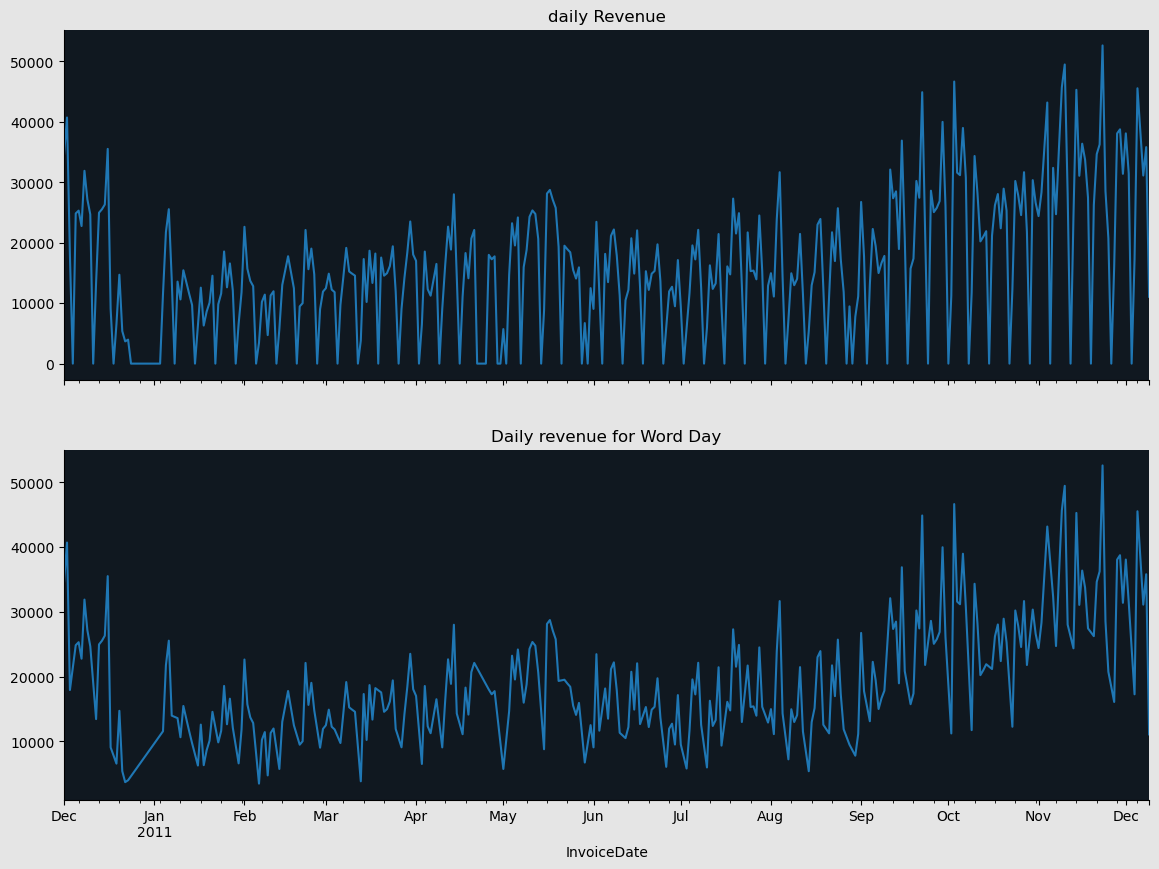

In [110]:
fig, axes = plt.subplots(2,1, sharex = True, figsize= (14,10), facecolor ="#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
    
daily_sales.TotalPrice.plot(ax =axes[0]).set_title("daily Revenue")
daily_sales_workdays.TotalPrice.plot(ax=axes[1]).set_title("Daily revenue for Word Day")

sns.despine()
plt.show()

## 5.2) Stationarity 

As we can see above daily revenue graphs, we have an increasing trend of trend for end of the years.

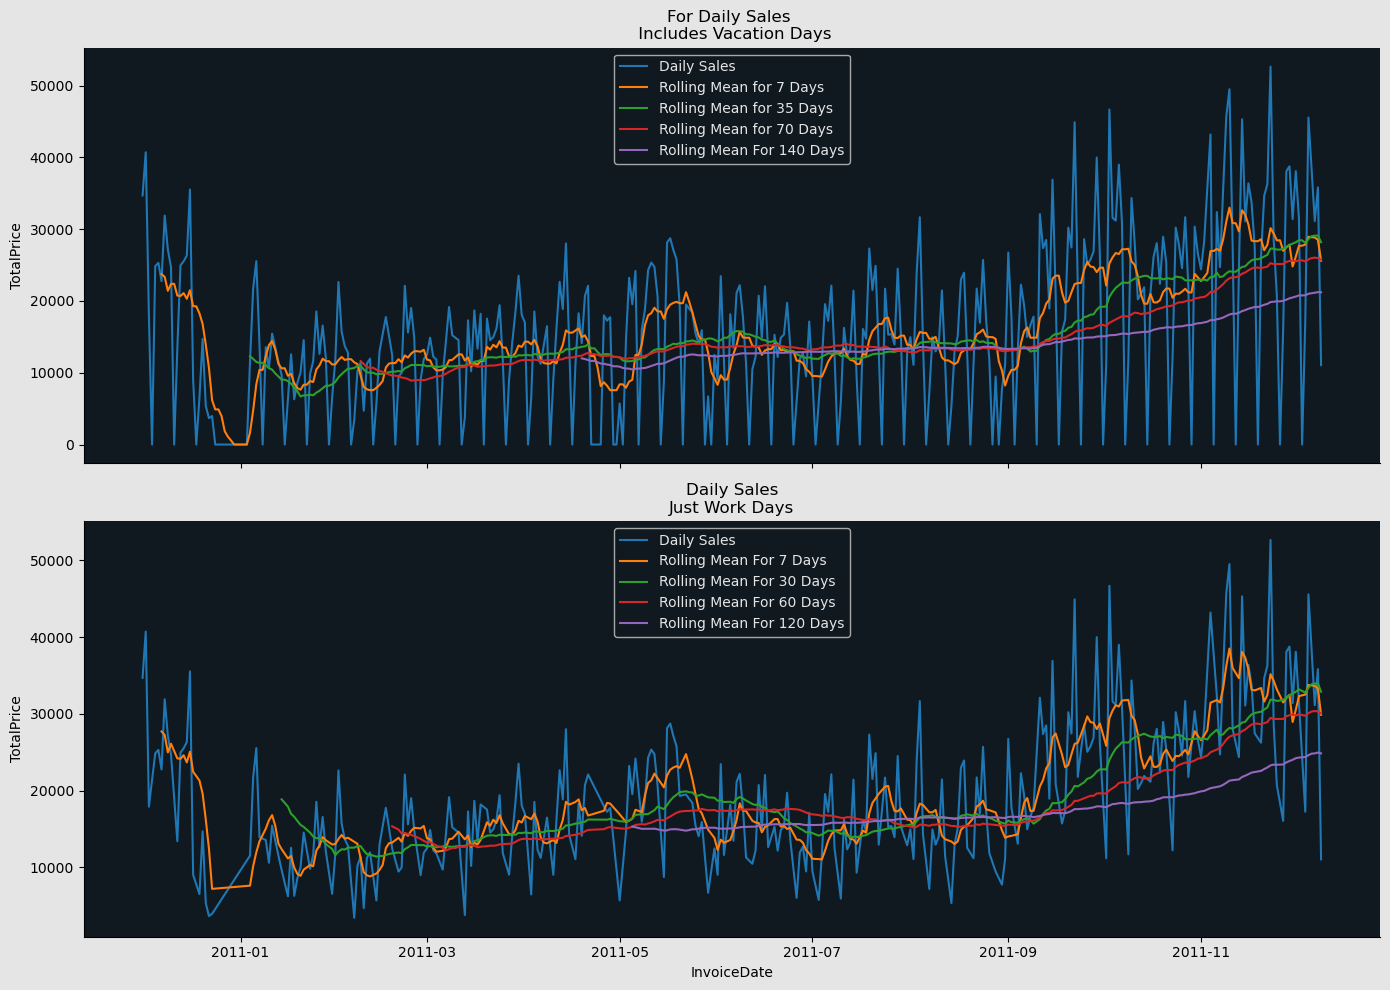

In [111]:
fig, axes = plt.subplots(2,1, sharex =True, figsize =(14,10), facecolor ="#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
                                
sns.lineplot(x = daily_sales.index, y=daily_sales.TotalPrice,
            ax =axes[0], label ='Daily Sales').set_title("For Daily Sales \n Includes Vacation Days")

sns.lineplot(x = daily_sales.index, y=daily_sales.TotalPrice.rolling(7).mean(),
            ax = axes[0], label ='Rolling Mean for 7 Days')
sns.lineplot(x =daily_sales.index, y =daily_sales.TotalPrice.rolling(35).mean(),
            ax =axes[0], label ='Rolling Mean for 35 Days')
sns.lineplot(x =daily_sales.index, y= daily_sales.TotalPrice.rolling(70).mean(),
            ax =axes[0], label="Rolling Mean for 70 Days")
sns.lineplot(x =daily_sales.index, y =daily_sales.TotalPrice.rolling(140).mean(),
            ax =axes[0], label ='Rolling Mean For 140 Days')
sns.lineplot(x =daily_sales_workdays.index, y =daily_sales_workdays.TotalPrice,
             ax =axes[1], label='Daily Sales').set_title('Daily Sales\nJust Work Days')

sns.lineplot(x =daily_sales_workdays.index, y =daily_sales_workdays.TotalPrice.rolling(6).mean(),
             ax =axes[1], label='Rolling Mean For 7 Days')
sns.lineplot(x =daily_sales_workdays.index, y =daily_sales_workdays.TotalPrice.rolling(30).mean(),
             ax =axes[1], label='Rolling Mean For 30 Days')
sns.lineplot(x =daily_sales_workdays.index, y =daily_sales_workdays.TotalPrice.rolling(60).mean(),
            ax =axes[1], label='Rolling Mean For 60 Days')
sns.lineplot(x =daily_sales_workdays.index, y =daily_sales_workdays.TotalPrice.rolling(120).mean(),
            ax =axes[1], label='Rolling Mean For 120 Days')

for ax in axes: ax.legend(facecolor ="#101820", labelcolor ="#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

**Let's check Stationarity means that, our series has constant mean, variance on difference tomes.**

In above rolling means plots, we saw that our values increase over time.

But, let's check it Augementted Dickey Fuller test.

## 5.2.1) Augmaneted Dickey-Fuller Test

In [116]:
def check_adf(series, check = 0.05):
    
    adf = adfuller(series, autolag ="AIC")
    
    print(f"H0: {series.name} is non-stationary")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0];
    print(f"ADF test statistic : {adf[0]}")
    pvalue = adf[1];
    print(f"p-value : {adf[1]}")
    print(f"Number of lags :{adf[2]}")
    print("Critical Values :\n")
    for key, item in adf[4].items():print("\t", key,"\t", item)
    
    print(f"\nFor {check} significance level: \n")
    
    if pvalue < check: 
        print("We can reject null hypothensis . This series id stationary.")
        
    else:
        print("We can not reject null hypothensis.  This series is non-stationary.")
    

In [118]:
print("Performing Augemented Dickey - Fuller test for Total Price \n")

check_adf(daily_sales.TotalPrice)

print("\n Performance Augemented Dickey - Fuller tets for Total Price (for wordays)\n")
check_adf(daily_sales_workdays.TotalPrice)

Performing Augemented Dickey - Fuller test for Total Price 

H0: TotalPrice is non-stationary
H1: TotalPrice is stationary.

ADF test statistic : -2.3693172111526097
p-value : 0.15058429130480327
Number of lags :16
Critical Values :

	 1% 	 -3.44880082033912
	 5% 	 -2.869670179576637
	 10% 	 -2.5711012838861036

For 0.05 significance level: 

We can not reject null hypothensis.  This series is non-stationary.

 Performance Augemented Dickey - Fuller tets for Total Price (for wordays)

H0: TotalPrice is non-stationary
H1: TotalPrice is stationary.

ADF test statistic : -1.6572549774464642
p-value : 0.45325954017237513
Number of lags :13
Critical Values :

	 1% 	 -3.4530232710482367
	 5% 	 -2.871523926671883
	 10% 	 -2.5720897694878424

For 0.05 significance level: 

We can not reject null hypothensis.  This series is non-stationary.


For ADF test, this seried is not stationary. To make it stationary, we have two main option.

1- take difference until become stationary
2- Apply transformations: Log, square root, etc.

We can take difference wwith using.diff() method.

Inthis problem , our series has seasinal behaivor. Our revenue is increasing from staturday to thurs day, then it desrese. For taking difference of seasonal series, we need set period in diff method.

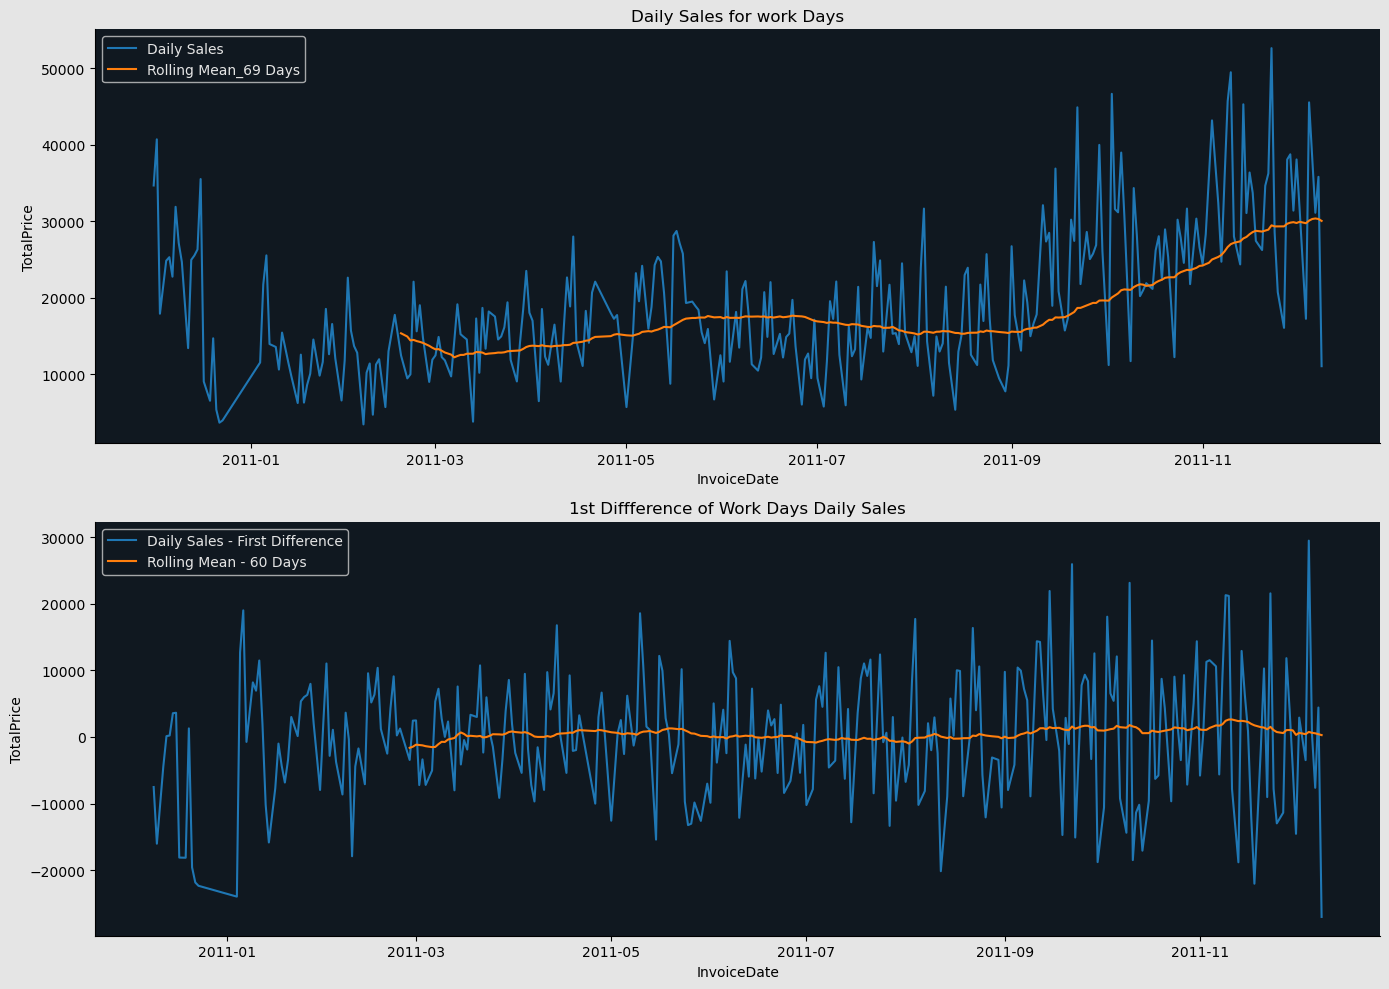

In [128]:
fig, axes = plt.subplots(2,1, figsize =(14,10), facecolor ="#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
    
sns.lineplot(x =daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice,
            ax =axes[0], label ='Daily Sales').set_title("Daily Sales for work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(),
            ax = axes[0] , label ="Rolling Mean_69 Days")

sns.lineplot(x =daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7),
            ax = axes[1], label ="Daily Sales - First Difference").set_title("1st Diffference of Work Days Daily Sales")
sns.lineplot( x =daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7).rolling(60).mean(),
            ax =axes[1], label ='Rolling Mean - 60 Days')
for ax in axes : ax.legend(facecolor ="#101820", labelcolor ='#e5e5e5')

sns.despine()
plt.tight_layout()
plt.show()

## 5.3) Seasonaltity, Decoposition

In [132]:
decompose =seasonal_decompose(daily_sales['TotalPrice'],period =7)


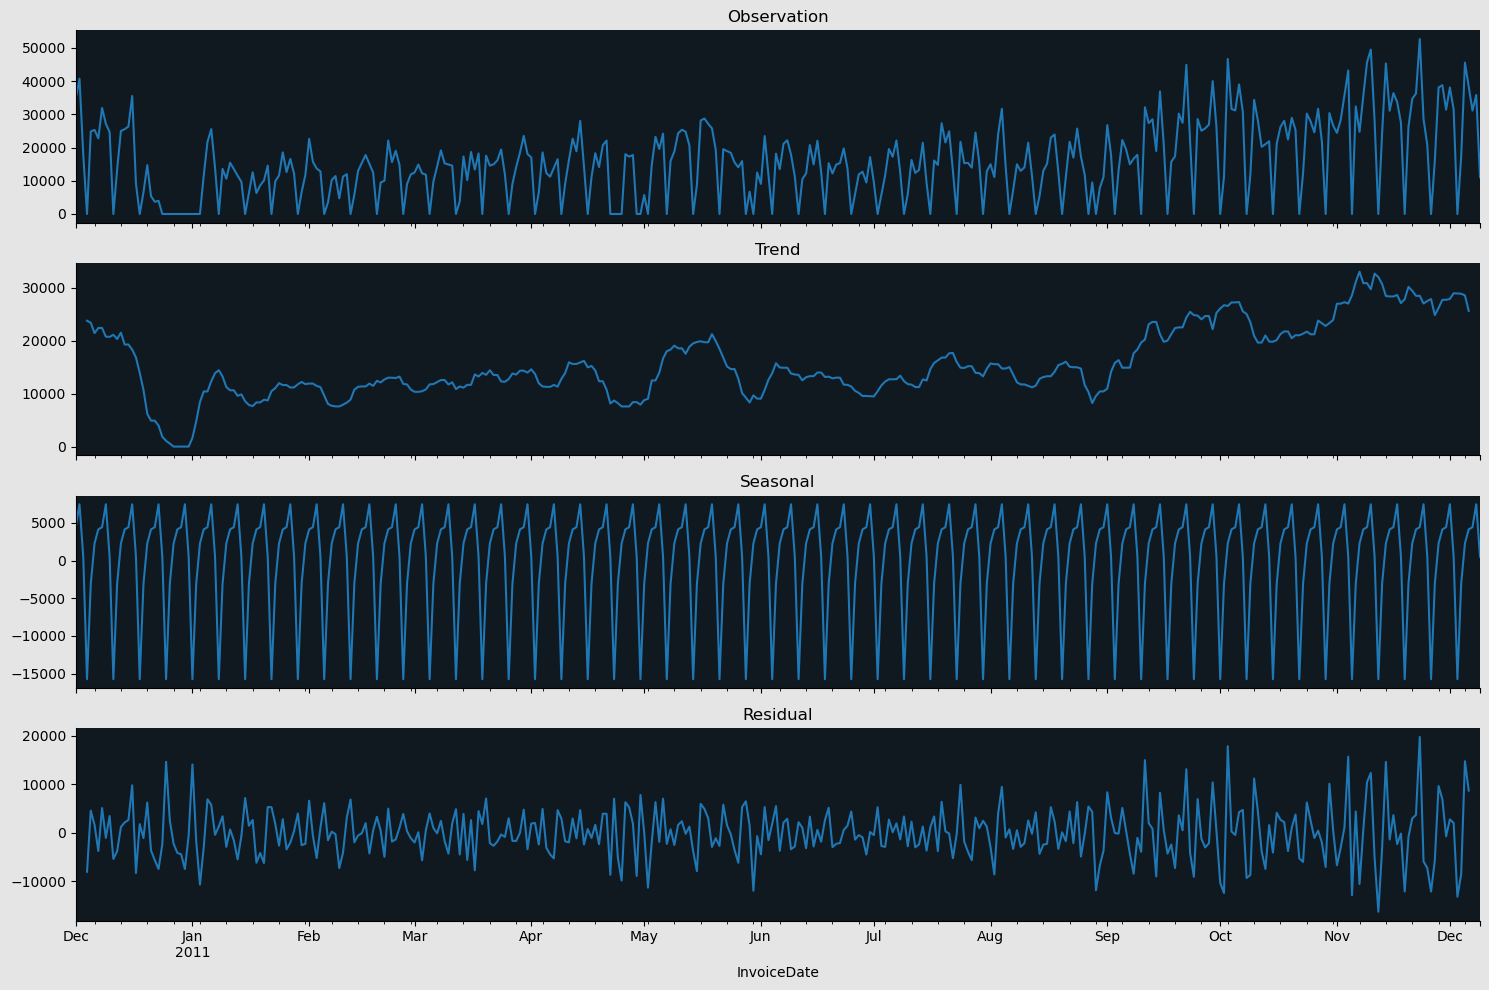

In [133]:
fig, axes = plt.subplots(4,1, sharex = True, figsize =(15,10), facecolor= '#e5e5e5')

for ax in axes : ax.set_facecolor("#101820")
    
decompose.observed.plot(ax = axes[0]).set_title("Observation")
decompose.trend.plot(ax =axes[1]).set_title("Trend")
decompose.seasonal.plot(ax =axes[2]).set_title("Seasonal")
decompose.resid.plot(ax =axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.show()

We can saw trend, seasonal component and residual. We know we have weekly seasonnality.

We need normal distributed residual. Let's look at it.

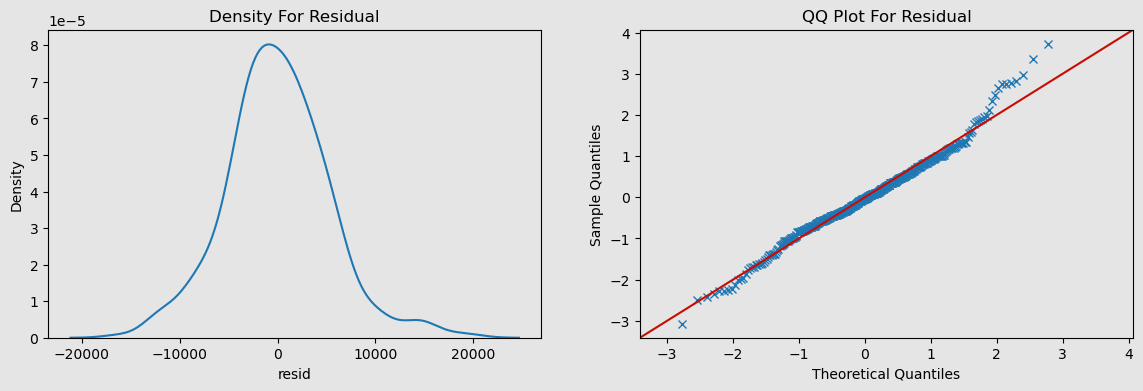

In [136]:
fig, axes =  plt.subplots(1,2, figsize =(14,4), facecolor ="#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density For Residual")

with warnings. catch_warnings():
    warnings.simplefilter("ignore")
    
    sm.qqplot(decompose.resid.dropna(), ax =axes[1], marker ='x', line = '45', fit =True)
    axes[1].set_title("QQ Plot For Residual")
    
plt.show()

As we can see kde plot and QQ plot, residual has normal distribution.

C:\Users\DeLL\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


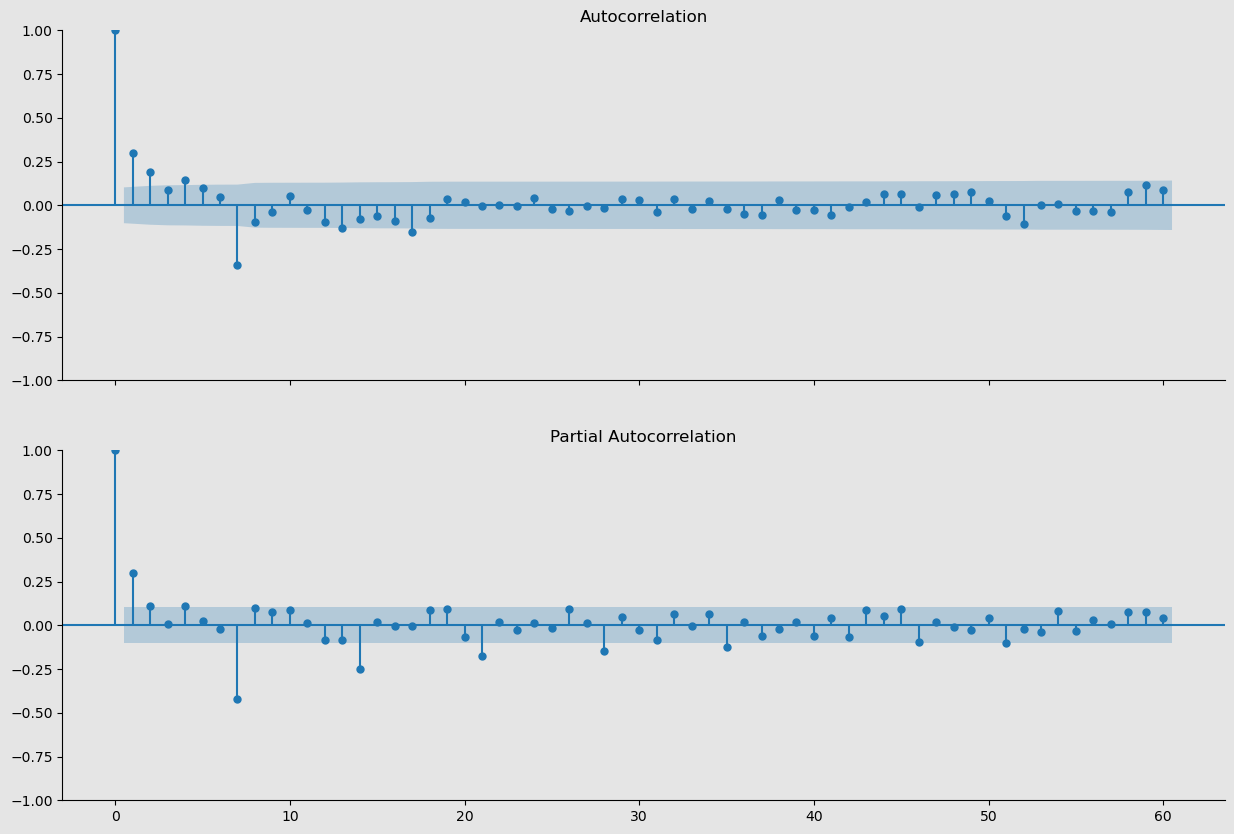

In [139]:
from statsmodels. graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,1, sharex = True , figsize =(15,10), facecolor ="#e5e5e5")

for ax in axes : ax.set_facecolor("#E5e5e5")
    
plot_acf(daily_sales['TotalPrice'].diff(7).dropna(), lags =60, ax =axes[0])
plot_pacf(daily_sales['TotalPrice'].diff(7).dropna(), lags = 60, ax =axes[1])

sns.despine()
plt.show()

## 5.4) Modelling 

I will daily sales data for model training. We have 0 values on staturdays, it is fixed. We can get rid of these records wwith subsetting the data, just like stock prices.

For traiing set, I hust get first 85% of all days, and remaining part is validation set.

First of all, I want to say again, may main goal is getting more detailed project about this dataset. As we talk theoretical part, I think this datset is not convenient for forecasting. We have one year dta and after the major peak, we don't have a lot observation to predicting the behavior of data.

This part would be a simple introduction of Facebook's Prophet, and I probably prepare more detailed notebooks about these concepts.

In [141]:
daily_data = daily_sales[['TotalPrice']].dropna().reset_index()

daily_data.columns =['ds','y']

train_size = int(0.85*len(daily_data))

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t {len(train)} \nValidation Days: \t {len(val)}")

Training Days:		 317 
Validation Days: 	 57


In [146]:
## Create function evaluation Model Prophet
def scores(y_true, y_pred):
    print(f"R2 : {r2_score(y_true, y_pred)}")
    print(f"MSE : {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

## 5.4.1) SImple Model

In [147]:
from prophet import Prophet

model  = Prophet()

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing


In [148]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2 : 0.5389254547221043
MSE : 42714306.251324266
Correlation: 0.7343603696609622

For Validation set: 

R2 : 0.46983675765450483
MSE : 95750120.0396335
Correlation: 0.8403313314854696


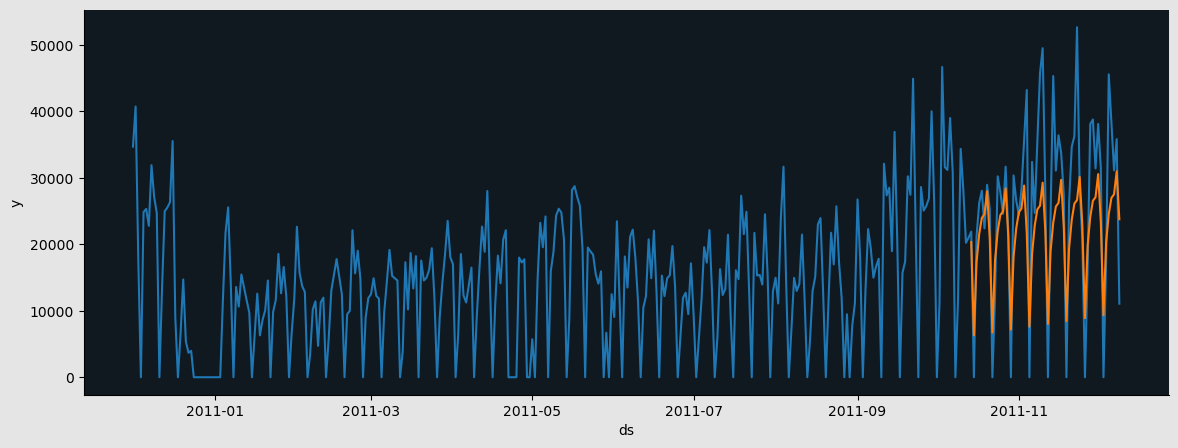

In [155]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax)

sns.despine()
plt.show()

It seems, the model does not capture huge peaks.

Let's add some parameters.

## 5.4.2) Prophet's parameters

We can add holidays to prophet model wwith brlow format.

I Just add "Black Friday" as a holiday for three years. 

In [157]:
black_friday =pd.DataFrame(
    {
        "holiday" : "black friday",
        'ds' : pd.to_datetime(['2011-11-24', '2012-11-23','2013-11-22']),
        "lower_window ":0,
        'upper_window ':1
    })

In saturdays, we don't have any sale record. I will simply add 'is_saturday' column as an extra regressor.

In [160]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == 'Saturday'
daily_data['is_saturday'] = daily_data['ds'].apply(is_saturday)

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

Prophet gices lots of option in model building step 
- holidays: You can use this for adding special days to model. 
- seasonality: If the data has seasonality, you can set daily_seasonality, weekly_seasonality and Year_seasonality parameters to True.
_Prior_scale : This parameter controls the flexibility of components affects.
Inthis model, I just set them with simple numbers. You can turn them wwith [0.01-10] range.

Also you can use add_country_holiday(country) method for adding all holidays for country.

In [161]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True,
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale =1,
)
model.add_country_holidays(country_name ='UK')

model.add_regressor("is_saturday")

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

21:51:20 - cmdstanpy - INFO - Chain [1] start processing
21:51:20 - cmdstanpy - INFO - Chain [1] done processing


In [162]:
print("For Training det: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set:\n")
scores(val.y, val_pred.yhat)


For Training det: 

R2 : 0.7229147033873067
MSE : 25669398.448617864
Correlation: 0.8503655979945185

For Validation set:

R2 : 0.4825422856328391
MSE : 93455438.45493846
Correlation: 0.8203654609016732


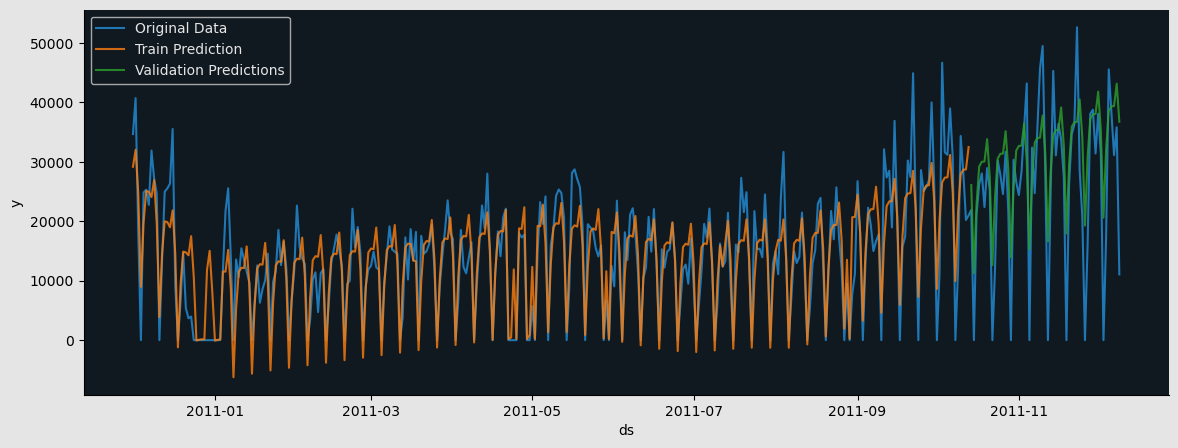

In [164]:
fig, ax = plt.subplots(figsize =(14,5), facecolor ="#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x =daily_data.ds, y =daily_data.y,ax =ax, label = "Original Data")
sns.lineplot(x =train_pred.ds, y =train_pred.yhat, alpha =0.8, ax =ax, label='Train Prediction')
sns.lineplot(x =val_pred.ds, y = val_pred.yhat, ax =ax, alpha =0.8, label ='Validation Predictions')

ax.legend(labelcolor ='#e5e5e5', facecolor ='#101820')
sns.despine()
plt.show()

We have a problem, we get negative valued forecasts. Actually, using "floor" and "cap" didn't work for me. http://facebook.github.io/prophet/docs/saturating_forecasts.html#saturating-minimum

To get rid of this, I will manually set them zero.

In [166]:
train_pred['yhat'] = np.where((train_pred.is_saturday ==0), train_pred.yhat,0)
val_pred['yhat'] = np.where((val_pred.is_saturday ==0), val_pred.yhat,0)

print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set:\n")
scores(val.y, val_pred.yhat)

For Training set: 

R2 : 0.7435843466984305
MSE : 23754546.536841102
Correlation: 0.8632268705871121

For Validation set:

R2 : 0.6871189184593856
MSE : 56507880.446605906
Correlation: 0.8513747798872398


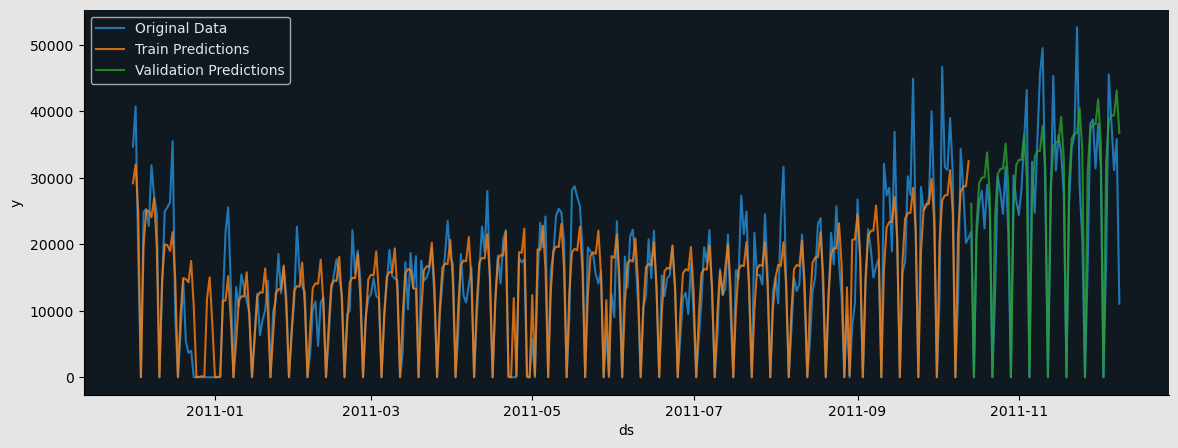

In [168]:
fig,ax = plt.subplots(figsize =(14,5), facecolor ="#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x =daily_data.ds, y =daily_data.y, ax =ax, label ='Original Data')
sns.lineplot(x =train_pred.ds, y=train_pred.yhat, alpha =0.8, label ='Train Predictions')
sns.lineplot(x = val_pred.ds, y =val_pred.yhat, ax =ax, alpha =0.8, label ="Validation Predictions")

ax.legend(labelcolor ="#e5e5e5", facecolor="#101820")
sns.despine()
plt.show()

## 5.4.3) Forecasting Future

In [170]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True,
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale =1,
    seasonality_prior_scale =5,
    changepoint_prior_scale =1,
)
model.add_country_holidays(country_name ="UK")
model.add_regressor("is_saturday")
model.fit(daily_data)

22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
future = model.make_future_dataframe(periods = 365)

future['Is_saturday'] = future['ds'].apply(is_saturday)
future.tail()

ds  Is_saturday
734 2012-12-04        False
735 2012-12-05        False
736 2012-12-06        False
737 2012-12-07        False
738 2012-12-08         True

In [172]:
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ValueError: Regressor 'is_saturday' missing from dataframe